<a href="https://www.kaggle.com/code/adrienmorel97/v-lib-forecast-xgboost?scriptVersionId=281726829" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<h1>Vélo-paris.fr — 60 minutes bike availability forecasting with XGBoost</h1>

<!-- Wrapper 16:9 qui coupe proprement l'image -->
<div
  style="
    position: relative;
    width: 100%;
    max-width: 960px;
    margin: 0 auto 8px;
    overflow: hidden;
    border-radius: 8px;
  "
>
  <!-- Ratio 16:9 via padding-top -->
  <div style="padding-top:56.25%;"></div>

  <!-- Image ancrée en bas, coupée en haut si besoin -->
  <img
    src="https://upload.wikimedia.org/wikipedia/commons/0/0a/Velib%E2%80%99_M%C3%A9tropole%2C_Paris%2C_France.jpg"
    alt="Vélib' Métropole, Paris"
    style="
      position: absolute;
      bottom: 0;
      left: 0;
      width: 100%;
      height: auto;
      display: block;
    "
  />
</div>

<sub>
  Photo by
  <a href="https://www.flickr.com/photos/sharonhahndarlin/53009396651">Sharon Hahn Darlin</a>
  via
  <a href="https://commons.wikimedia.org/wiki/File:Velib%E2%80%99_M%C3%A9tropole,_Paris,_France.jpg">Wikimedia Commons</a>,
  licensed under
  <a href="https://creativecommons.org/licenses/by/2.0/">CC BY 2.0</a>.
</sub>

<br></br>
## 1. Project overview

This notebook is an exploratory training notebook that was used at the
beginning of the [velo-paris.fr](https://velo-paris.fr) project.

The goal is to build a **short-term forecasting model** for the
Vélib' Métropole bike-sharing system in Paris:

> Given the current state of a station at time \\( t \\), predict the number
> of bikes available at the same station at time \\( t + H \\) minutes.

In this notebook, we focus on:

- preparing a **clean modeling frame** from raw 5-minute snapshots,
- engineering **temporal, spatial and operational features**,
- training a **gradient-boosted tree model (XGBoost)**,
- analysing **feature importance** and performing **feature reduction**,
- evaluating the model on a **time-based validation split**.


In [1]:
# ====================================================================
# Imports and global configuration
# ====================================================================

import warnings
from typing import List, Optional, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import folium
import xgboost as xgb
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error

# Optional on Kaggle: uncomment if needed
# !pip -q install kagglehub[pandas-datasets] pyarrow

import kagglehub
from kagglehub import KaggleDatasetAdapter

warnings.filterwarnings("ignore")

# Kaggle dataset configuration
DATASET_SLUG = "adrienmorel97/velib-data"
FILE_PATH    = "velib_concat.parquet"   # or "" to concatenate all parquet files

# Forecasting configuration
H            = 60        # horizon in minutes
BIN_MIN      = 5         # bin size in minutes
FRAC_VALID   = 0.10      # share of data in validation
USE_LAST_N_DAYS: Optional[int] = 30  # None to use the full history
RANDOM_STATE = 42

# XGBoost hyperparameters (from a previous Optuna search)
BEST_HP = {
    "max_depth": 9,
    "min_child_weight": 12.069513333409786,
    "subsample": 0.921794267137362,
    "colsample_bytree": 0.8626519260631821,
    "reg_lambda": 6.138345907522556,
    "reg_alpha": 2.8148536329754985,
    "learning_rate": 0.05014616293868097,
    "max_bin": 128,
    "n_estimators": 900,
}

BASE_PARAMS = {
    "objective": "reg:squarederror",
    "eval_metric": "mae",
    "tree_method": "hist",
    "random_state": RANDOM_STATE,
}

## 2. Dataset description

In [2]:
def load_kaggle_dataset(dataset_slug: str, file_path: str) -> pd.DataFrame:
    """
    Load a parquet dataset from Kaggle using KaggleHub.

    - If file_path is provided, load a single file.
    - Otherwise, list all parquet files in the dataset and concatenate them.
    """
    if file_path:
        print(f"• Loading single file: {dataset_slug} :: {file_path}")
        df = kagglehub.load_dataset(
            KaggleDatasetAdapter.PANDAS,
            dataset_slug,
            file_path,
            pandas_kwargs={"engine": "pyarrow"},
        )
        return df

    print(f"• No file_path provided → listing files in dataset: {dataset_slug}")
    meta = kagglehub.dataset_metadata(dataset_slug)
    files = [f["name"] for f in meta["files"] if f["name"].endswith(".parquet")]
    if not files:
        raise FileNotFoundError("No .parquet files found in the dataset.")

    print(f"  Found {len(files)} parquet(s). Concatenating…")
    parts: List[pd.DataFrame] = []
    for name in files:
        print("   -", name)
        df_part = kagglehub.load_dataset(
            KaggleDatasetAdapter.PANDAS,
            dataset_slug,
            name,
            pandas_kwargs={"engine": "pyarrow"},
        )
        parts.append(df_part)
    df = pd.concat(parts, ignore_index=True)
    return df


df_raw = load_kaggle_dataset(DATASET_SLUG, FILE_PATH)
print("Raw shape:", df_raw.shape)
df_raw.head()

• Loading single file: adrienmorel97/velib-data :: velib_concat.parquet
Raw shape: (7303001, 14)


ts_utc   tbin_utc  station_id  bikes  capacity  \
0 2025-11-04 00:01:02.751417 2025-11-04        6245      8        27   
1 2025-11-04 00:01:02.751417 2025-11-04        6293      1        28   
2 2025-11-04 00:01:02.751417 2025-11-04        6294      4        23   
3 2025-11-04 00:01:02.751417 2025-11-04        6295      7        23   
4 2025-11-04 00:01:02.751417 2025-11-04        6296      9        17   

   mechanical  ebike status        lat       lon                     name  \
0           5      3     OK  48.866811  2.334388        Ventadour - Opéra   
1           1      0     OK  48.867219  2.340463           Mairie du 2ème   
2           3      1     OK  48.855258  2.347375        Marché aux fleurs   
3           6      1     OK  48.850458  2.352454  Pontoise - La Tournelle   
4           8      1     OK  48.857616  2.335831       Institut de France   

   temp_C  precip_mm  wind_mps  
0    12.1        0.0      2.75  
1    12.1        0.0      2.75  
2    12.1        0.0      2.75  
3    12.1        0.0      2.75  
4    12.1        0.0      2.75

### 2.1 Dataset schema (high-level)

The base table contains one row per **station × 5-minute time bin**:

- `ts_utc`      — raw timestamp of the API snapshot (UTC, 5-minute cadence).
- `tbin_utc`    — time bin (UTC) aligned on a fixed 5-minute grid.
- `station_id`  — unique station identifier (integer).
- `bikes`       — total number of bikes currently docked.
- `capacity`    — total number of docks at the station.
- `mechanical`  — number of mechanical bikes.
- `ebike`       — number of e-bikes.
- `status`      — station status (e.g. `OK`, `CLOSED`), as a categorical string.
- `lat`, `lon`  — station latitude and longitude (WGS84).
- `name`        — human-readable station name from the official feed.
- `temp_C`      — air temperature in degrees Celsius (aligned to the time bin).
- `precip_mm`   — precipitation amount in millimetres.
- `wind_mps`    — wind speed in metres per second.

Each row represents the **current operational and weather context** of a station
at time \\( t \\). The objective is to forecast the number of available bikes
at the same station at time \\( t + 60 \\) minutes.

In [3]:
print("Columns:", list(df_raw.columns))
print("\nInfo:")
print(df_raw.info())

print("\nBasic describe on numeric columns:")
df_raw.describe().T.head(15)

Columns: ['ts_utc', 'tbin_utc', 'station_id', 'bikes', 'capacity', 'mechanical', 'ebike', 'status', 'lat', 'lon', 'name', 'temp_C', 'precip_mm', 'wind_mps']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7303001 entries, 0 to 7303000
Data columns (total 14 columns):
 #   Column      Dtype         
---  ------      -----         
 0   ts_utc      datetime64[ns]
 1   tbin_utc    datetime64[ns]
 2   station_id  Int64         
 3   bikes       Int64         
 4   capacity    Int64         
 5   mechanical  Int64         
 6   ebike       Int64         
 7   status      string        
 8   lat         float64       
 9   lon         float64       
 10  name        string        
 11  temp_C      float64       
 12  precip_mm   float64       
 13  wind_mps    float64       
dtypes: Int64(5), datetime64[ns](2), float64(5), string(2)
memory usage: 814.9 MB
None

Basic describe on numeric columns:


count                           mean  \
ts_utc        7303001  2025-11-13 14:35:02.449864960   
tbin_utc      7303001  2025-11-13 14:34:18.361172224   
station_id  7303001.0              2507994057.076521   
bikes       7303001.0                      12.339738   
capacity    7303001.0                      31.775678   
mechanical  7303001.0                       7.721663   
ebike       7303001.0                       4.584383   
lat         7303001.0                      48.857847   
lon         7303001.0                       2.341856   
temp_C      7297001.0                       9.835028   
precip_mm   7297001.0                       0.069718   
wind_mps    7297001.0                       2.484528   

                                   min                            25%  \
ts_utc      2025-11-04 00:01:02.751417  2025-11-08 05:55:33.785814016   
tbin_utc           2025-11-04 00:00:00            2025-11-08 05:55:00   
station_id                      6245.0                     66491392.0   
bikes                              0.0                            4.0   
capacity                           0.0                           23.0   
mechanical                         0.0                            1.0   
ebike                              0.0                            2.0   
lat                          48.743386                      48.836817   
lon                           2.165597                       2.302599   
temp_C                            -1.9                            6.5   
precip_mm                          0.0                            0.0   
wind_mps                          0.22                           1.75   

                                      50%                            75%  \
ts_utc      2025-11-13 11:30:49.144111104  2025-11-18 18:45:53.596871936   
tbin_utc              2025-11-13 11:30:00            2025-11-18 18:45:00   
station_id                    210748575.0                    653208733.0   
bikes                                 9.0                           18.0   
capacity                             30.0                           38.0   
mechanical                            4.0                           11.0   
ebike                                 3.0                            6.0   
lat                             48.858256                      48.879494   
lon                              2.343996                       2.379841   
temp_C                               10.4                           13.7   
precip_mm                             0.0                            0.0   
wind_mps                             2.56                           3.18   

                                   max                std  
ts_utc      2025-11-23 23:55:44.425799                NaN  
tbin_utc           2025-11-23 23:55:00                NaN  
station_id               20824565291.0  5749286488.068697  
bikes                             79.0          11.098321  
capacity                         105.0          12.669601  
mechanical                        76.0           9.446705  
ebike                             53.0           4.379151  
lat                          48.957568           0.032555  
lon                           2.538242           0.058432  
temp_C                            19.4           4.948861  
precip_mm                          2.6           0.306936  
wind_mps                          6.53           1.012831

We first check basic schema and data types to ensure the frame is consistent
before any feature engineering.

In [4]:
missing = df_raw.isna().mean().sort_values(ascending=False) * 100
missing = missing[missing > 0]

print("Columns with missing values (% of rows):")
missing

Columns with missing values (% of rows):


wind_mps     0.082158
precip_mm    0.082158
temp_C       0.082158
dtype: float64

Min ts_utc: 2025-11-04 00:01:02.751417
Max ts_utc: 2025-11-23 23:55:44.425799

Daily counts (number of rows per day):


Text(0, 0.5, 'Rows')

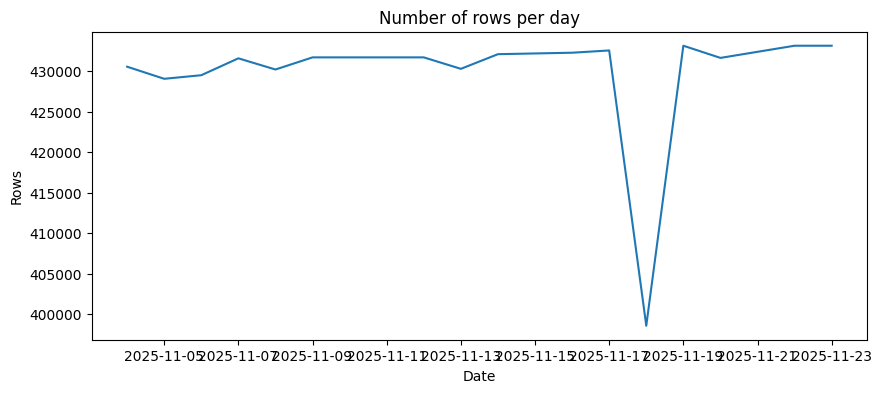

In [5]:
print("Min ts_utc:", df_raw["ts_utc"].min())
print("Max ts_utc:", df_raw["ts_utc"].max())

# Daily coverage: number of 5-min snapshots per day
df_raw["date"] = pd.to_datetime(df_raw["ts_utc"]).dt.date
daily_counts = df_raw.groupby("date")["station_id"].count()

print("\nDaily counts (number of rows per day):")
daily_counts.head()

# For plotting, you can use pandas built-in plotting if you like:
ax = daily_counts.plot(kind="line", figsize=(10, 4), title="Number of rows per day")
ax.set_xlabel("Date")
ax.set_ylabel("Rows")


In [6]:
n_stations = df_raw["station_id"].nunique()
print("Number of unique stations:", n_stations)

station_meta = df_raw[["station_id", "lat", "lon", "capacity"]].drop_duplicates("station_id")
station_meta.describe().T

Number of unique stations: 1505


count               mean                std        min  \
station_id  1505.0  2565593620.942193  5831791636.720161     6245.0   
lat         1505.0          48.857774           0.032669  48.743386   
lon         1505.0           2.342004           0.058553   2.165597   
capacity    1505.0          31.664452          12.875569        0.0   

                   25%          50%          75%            max  
station_id  66491393.0  210751059.0  813544903.0  20824565291.0  
lat          48.836718    48.858256    48.879494      48.957568  
lon           2.302658     2.344037     2.380039       2.538242  
capacity          23.0         30.0         38.0          100.0

### 2.2 Basic filtering and cleaning

Before building features, we apply a few sanity filters:

- restrict to **valid stations** with non-null coordinates and capacity,
- keep only **operational snapshots** (e.g. `OPEN`),
- remove obviously inconsistent rows (negative counts, extreme capacities),
- normalise types (timestamps, integers, floats).

The objective is not to over-optimise cleaning here, but to ensure that:

- the target `y_nb` is well-defined,
- feature engineering steps will not propagate NaNs or inconsistencies,
- the resulting modeling frame remains close to what can be produced daily
  in production.

In [7]:
def basic_typing(df: pd.DataFrame) -> pd.DataFrame:
    """
    Basic schema normalization:
    - enforce datetime types for timestamps,
    - cast bike / capacity counts to numeric,
    - cast status / name to string,
    - keep the last snapshot per (station_id, tbin_utc).
    """
    df = df.copy()
    for c in ["ts_utc", "tbin_utc"]:
        df[c] = pd.to_datetime(df[c])

    for c in ["bikes", "capacity", "mechanical", "ebike"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    df["status"] = df["status"].astype("string")
    df["name"]   = df["name"].astype("string")

    # Keep the latest snapshot for each (station_id, tbin_utc)
    df = (
        df.sort_values(["station_id", "tbin_utc", "ts_utc"])
          .groupby(["station_id", "tbin_utc"], as_index=False)
          .tail(1)
          .reset_index(drop=True)
    )
    return df


df = basic_typing(df_raw)
print("After typing & deduplication:", df.shape)

if USE_LAST_N_DAYS:
    tmax = df["tbin_utc"].max()
    tmin = tmax - pd.Timedelta(days=int(USE_LAST_N_DAYS))
    df = df[df["tbin_utc"] >= tmin].reset_index(drop=True)
    print(f"Restricted to last {USE_LAST_N_DAYS} days:", df.shape)

After typing & deduplication: (7303001, 15)
Restricted to last 30 days: (7303001, 15)


## 3. Exploratory Data Analysis

Before building any forecasting model, we start with an exploratory analysis
of the raw station × time dataset.  
The goal is to understand the **structure**, the **scale**, and the **behaviour**
of the Vélib’ network over time.

This EDA focuses on a few key questions:

1. **Temporal structure**  
   How do bike counts evolve within a day?  
   Are there identifiable patterns (morning peaks, evening returns, weekday/weekend contrasts)?

2. **Spatial structure**  
   How are stations distributed across Paris?  
   Do capacity, usage levels, or spatial density vary systematically across areas?

3. **Operational patterns**  
   What is the typical relationship between `bikes`, `mechanical`, `ebike`, and `capacity`?  
   How often are stations closed or in degraded status?

4. **Weather interactions**  
   How do temperature, rain, and wind correlate with usage?

5. **Feature behaviour before engineering**  
   We inspect distributions, correlations, and temporal dynamics of the raw fields
   to guide the feature engineering pipeline.

The EDA does not attempt to model or predict anything yet — it provides
the **intuition and evidence** required to design an effective forecasting model.


### 3.1 Station footprint & capacity distribution

Before diving into time series dynamics, we start with the spatial
footprint of the Vélib' network and the distribution of station capacities.

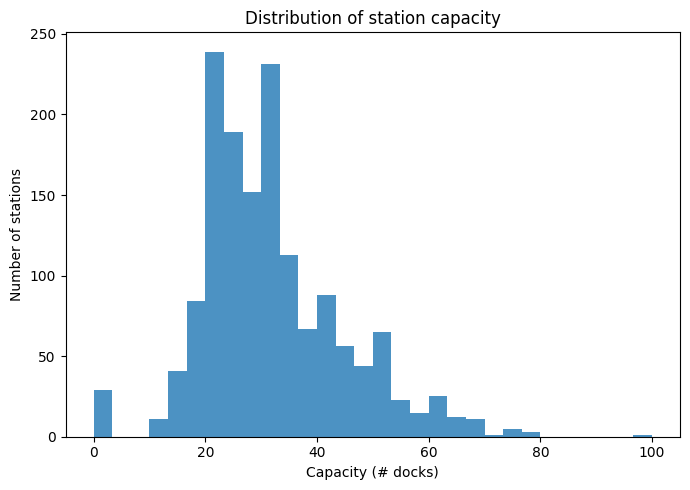

In [8]:
station_meta = df[["station_id", "lat", "lon", "capacity"]].drop_duplicates("station_id")

plt.figure(figsize=(7, 5))
plt.hist(station_meta["capacity"], bins=30, alpha=0.8)
plt.title("Distribution of station capacity")
plt.xlabel("Capacity (# docks)")
plt.ylabel("Number of stations")
plt.tight_layout()
plt.show()

The distribution of station capacities is highly asymmetric but well-structured:

- Most stations offer **between 15 and 35 docks**, which corresponds to the core of the Vélib’ network.  
- A secondary cluster appears around **40–60 docks**, representing larger hubs (major intersections, transport nodes).  
- A few stations exceed **70+ docks**, acting as high-capacity anchors.  
- Very small stations (<10 docks) exist but remain rare.

This distribution confirms that the network is dense and relatively homogeneous, with a long tail of large stations.  
It also suggests that capacity is a meaningful predictor:  
larger stations tend to host more bikes, show more stable dynamics, and play a structurally different role in the system.

In [9]:
# Station meta (unique stations with lat/lon/capacity)
station_meta = (
    df[["station_id", "lat", "lon", "capacity"]]
    .drop_duplicates("station_id")
    .dropna(subset=["lat", "lon", "capacity"])
)

# Map center = mean lat/lon
lat_center = station_meta["lat"].mean()
lon_center = station_meta["lon"].mean()

# Use a clipped range for capacity to avoid a few huge stations dominating the scale
cap_min, cap_max = station_meta["capacity"].quantile([0.05, 0.95])

def capacity_to_radius(cap: float) -> float:
    """Map station capacity to a reasonable circle radius for plotting."""
    cap_clipped = min(max(cap, cap_min), cap_max)
    # radius between 2 and 10 pixels
    return 2.0 + 8.0 * (cap_clipped - cap_min) / (cap_max - cap_min + 1e-9)

# Create Leaflet map
m = folium.Map(
    location=[lat_center, lon_center],
    zoom_start=11.5,
    tiles="CartoDB positron",
)

# Add one circle marker per station
for row in station_meta.itertuples():
    r = capacity_to_radius(row.capacity)
    folium.CircleMarker(
        location=[row.lat, row.lon],
        radius=r,
        color=None,
        fill=True,
        fill_opacity=0.6,
        popup=f"Station {row.station_id}<br>Capacity: {row.capacity}",
    ).add_to(m)

m

### 3.2 Time series example – dynamics of a single station

To understand the intra-day cycling patterns of the bike-sharing system,
we inspect the time series of a single representative station.

This reveals:
- daily refill cycles,
- morning and evening usage peaks,
- stability or instability of the station,
- saturation or empty events,
- weekday/weekend differences.

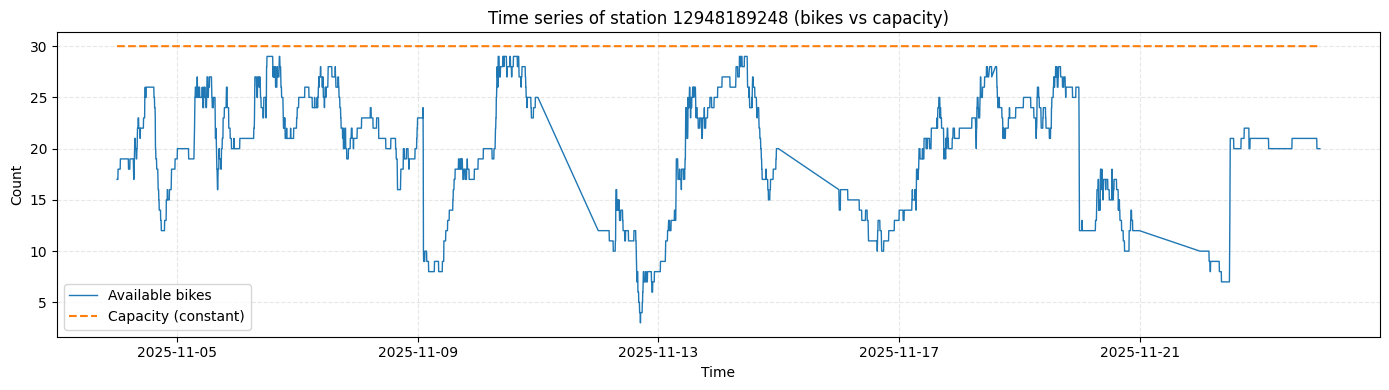

In [10]:
# Pick a "representative" station: median capacity
station_meta = df[["station_id", "capacity"]].drop_duplicates("station_id")
median_capacity = station_meta["capacity"].median()

# nearest station to median capacity
station_repr = (
    station_meta.iloc[(station_meta["capacity"] - median_capacity).abs().argsort()]
    .iloc[0]["station_id"]
)

# Extract the time series for the representative station
ts = df[df["station_id"] == station_repr].copy()
ts = ts.sort_values("tbin_utc").reset_index(drop=True)

plt.figure(figsize=(14, 4))
plt.plot(ts["tbin_utc"], ts["bikes"], label="Available bikes", linewidth=1)
plt.plot(ts["tbin_utc"], ts["capacity"], label="Capacity (constant)", linestyle="--")

plt.title(f"Time series of station {station_repr} (bikes vs capacity)")
plt.xlabel("Time")
plt.ylabel("Count")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

The multi-day time series reveals a clear and regular usage pattern:

- The station rarely reaches its maximum capacity: the orange line remains mostly untouched,
  confirming that this location experiences continual throughput.
- Daily dynamics are strong: we observe repeated cycles of **morning departures** followed by
  **evening returns**, characteristic of commuter behaviour.
- Sharp drops (e.g., early morning troughs) suggest intense pickup bursts, often aligned with
  working-day schedules.
- Small plateaus and abrupt changes likely correspond to external operations:
  redistribution trucks, maintenance windows, or momentary station closures.

This long-range view confirms that bike availability is dominated by **daily periodicity** and
**operational interventions**, both of which motivate the use of temporal and lagged features
in the forecasting model.

### 2.1 Intra-day zoom for the representative station

To better understand daily cycling patterns, we zoom into a single day.
This view reveals:
- morning peak,
- mid-day plateau,
- evening returns,
- sudden empty/full events,
- irregularities (maintenance, anomalies, weather effects).

Chosen day: 2025-11-04


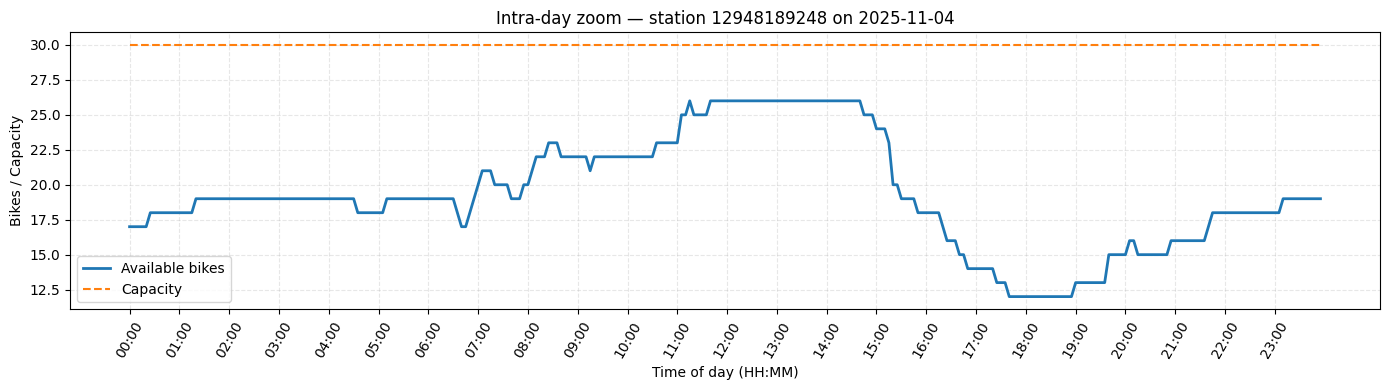

In [11]:
# Recompute or reuse the representative station
station_ts = df[df["station_id"] == station_repr].copy()
station_ts = station_ts.sort_values("tbin_utc")

# Choose the first full day present in the dataset
first_day = station_ts["tbin_utc"].dt.date.min()
chosen_day = first_day

print("Chosen day:", chosen_day)

day_ts = station_ts[station_ts["tbin_utc"].dt.date == chosen_day].copy()

# Extract hour-minute string for labels
day_ts["hm"] = day_ts["tbin_utc"].dt.strftime("%H:%M")

# Numeric x-axis
x = np.arange(len(day_ts))

plt.figure(figsize=(14, 4))
plt.plot(x, day_ts["bikes"], label="Available bikes", linewidth=2)
plt.plot(x, day_ts["capacity"], label="Capacity", linestyle="--")

# Ticks only at full hours (minute == 0)
full_hour_mask = day_ts["tbin_utc"].dt.minute == 0
tick_positions = x[full_hour_mask]
tick_labels = day_ts.loc[full_hour_mask, "hm"]

plt.xticks(tick_positions, tick_labels, rotation=60)

plt.title(f"Intra-day zoom — station {station_repr} on {chosen_day}")
plt.xlabel("Time of day (HH:MM)")
plt.ylabel("Bikes / Capacity")
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

For this representative station on 2025-11-04, the intra-day profile is very structured:

- **Night-time plateau (00:00–06:00)**  
  Availability is remarkably stable around **17–19 bikes**, indicating low usage and a well-filled station overnight.

- **Morning build-up (06:30–08:30)**  
  Rather than a depletion, we observe a **gradual increase** from ~18 to **22–23 bikes**.  
  This suggests that the station behaves more like an *arrival* point in the morning (people coming in) than a departure hub.

- **Midday saturation (11:00–14:30)**  
  From late morning to early afternoon the station sits close to its upper band, with **25–26 bikes** almost continuously.  
  The station is effectively near its operational “ceiling”, which matches the heatmap signal.

- **Afternoon drain (15:00–18:30)**  
  After 15:00, availability decreases steadily from **26 down to 12–14 bikes**.  
  This is a classic **end-of-day departure pattern**, where users take bikes away and the station is not fully replenished.

- **Evening partial recovery (19:00–23:55)**  
  The station then gradually climbs back to **18–19 bikes**, returning close to its night-time baseline.

Overall, this single day already shows the key behaviours the model must learn:

- a **daily cycle with clear phases** (night plateau → build-up → midday saturation → afternoon drain → evening recovery),
- **asymmetry between morning and evening** (arrivals vs departures),
- and a station that rarely hits hard limits (0 or full capacity), which makes it well suited to regression rather than a pure classification on “empty / full”.

### 3.3 Hour × date heatmap for the representative station

To capture the behavioural signature of a station, we build a heatmap where:

- each row = a calendar date,
- each column = an hour of the day,
- each cell = mean occupancy ratio (bikes / capacity).

This highlights:
- weekday vs weekend patterns,
- morning/evening asymmetry,
- unusually empty/full days,
- structural differences between station types.

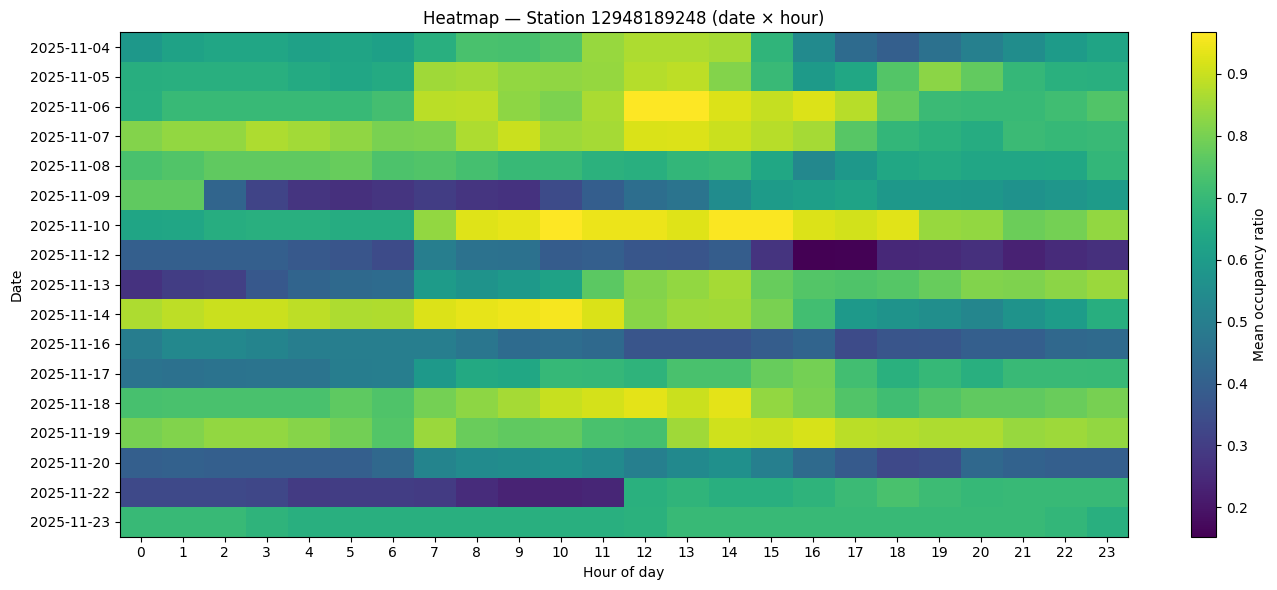

In [12]:
# Extract time series for the representative station
ts = df[df["station_id"] == station_repr].copy()
ts = ts.sort_values("tbin_utc")

# Occupancy ratio
ts = ts[ts["capacity"] > 0].copy()
ts["occ_ratio"] = (ts["bikes"] / ts["capacity"]).clip(0, 2)

# Extract date and hour
ts["date"] = ts["tbin_utc"].dt.date
ts["hour"] = ts["tbin_utc"].dt.hour

# Pivot: rows = date, columns = hour
heat = (
    ts.groupby(["date", "hour"])["occ_ratio"]
    .mean()
    .unstack(level=1)
    .fillna(0.0)
    .astype(float)
)

plt.figure(figsize=(14, 6))
plt.imshow(heat.values, aspect="auto")
plt.colorbar(label="Mean occupancy ratio")

plt.title(f"Heatmap — Station {station_repr} (date × hour)")
plt.xlabel("Hour of day")
plt.ylabel("Date")

plt.xticks(ticks=np.arange(24), labels=np.arange(24))
plt.yticks(
    ticks=np.arange(len(heat.index)),
    labels=[str(d) for d in heat.index]
)

plt.tight_layout()
plt.show()

This heatmap highlights the joint temporal structure of the station across days and hours:

- **Strong diurnal patterns** dominate almost every day: availability typically rises overnight,
  dips in the morning as commuters depart, and partially recovers in the afternoon.
- A few days exhibit **distinct anomalies** (e.g., 2025-11-09, 2025-11-13): extended low occupancy
  suggests a mix of heavy usage, redistribution delays, or operational interventions.
- Weekends (e.g., 2025-11-08 and 2025-11-15/16) display smoother curves with less pronounced peaks,
  consistent with recreational rather than commuter use.
- Midday values often approach **high occupancy ratios**, reflecting station saturation around lunch hours.
- The overall structure confirms that a single station exhibits rich, multi-scale temporal dynamics:
  daily periodicity, weekday/weekend shifts, and irregular shocks.

These observations justify the inclusion of **hour-of-day encodings**, **rolling window features**,  
and **lag features** in the forecasting model, as they capture the recurring and irregular temporal patterns visible here.

### 3.1 Operational patterns — bikes, mechanical, ebike, capacity

We first explore the relationship between:

- the total number of bikes at a station,
- its capacity,
- the mechanical / e-bike breakdown,
- and the station operational status.

This helps validate the consistency of the raw data and understand typical
usage and fleet composition across the network.


Operational EDA: sampled 200000 rows out of 7303001
Sanity check: bikes - (mechanical + ebike)
count    200000.0
mean     0.034615
std      0.864471
min           0.0
25%           0.0
50%           0.0
75%           0.0
max          55.0
Name: bikes_diff, dtype: Float64


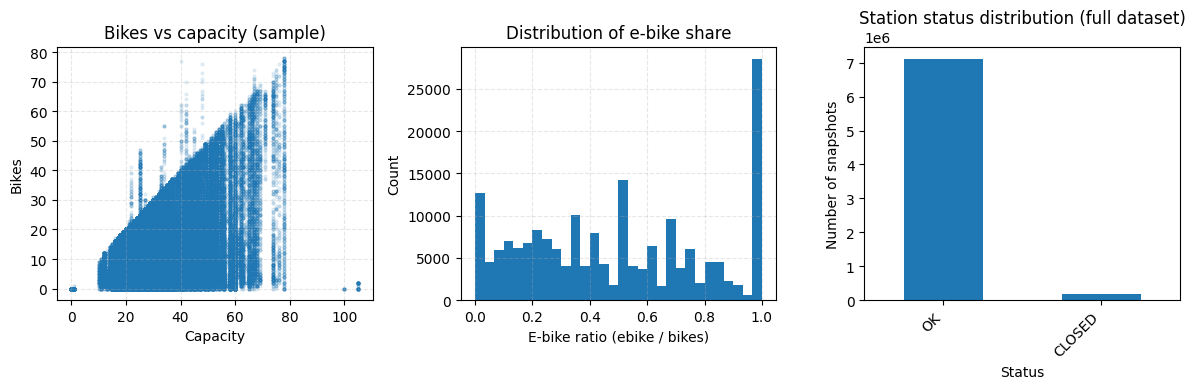

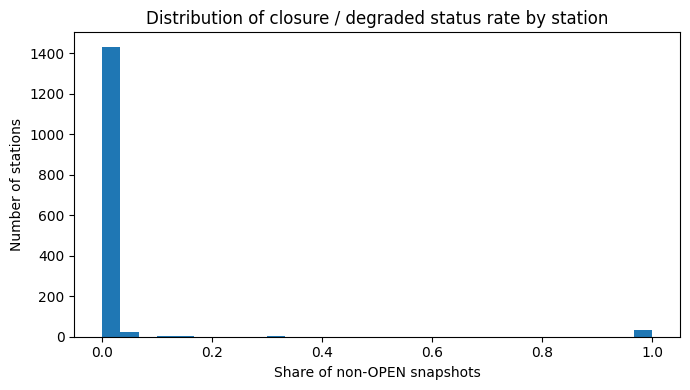

In [13]:
# =====================================================================
# EDA — Operational patterns
# =====================================================================

MAX_ROWS_OP = 200_000

if len(df) > MAX_ROWS_OP:
    df_op = df.sample(MAX_ROWS_OP, random_state=RANDOM_STATE)
    print(f"Operational EDA: sampled {MAX_ROWS_OP} rows out of {len(df)}")
else:
    df_op = df.copy()
    print(f"Operational EDA: using all {len(df)} rows")

# Sanity check: bikes vs mechanical + ebike
df_op["bikes_diff"] = df_op["bikes"] - (df_op["mechanical"] + df_op["ebike"])

print("Sanity check: bikes - (mechanical + ebike)")
print(df_op["bikes_diff"].describe())

# Ratio of ebikes
df_op["ebike_ratio"] = df_op["ebike"] / df_op["bikes"].replace(0, np.nan)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.scatter(
    df_op["capacity"],
    df_op["bikes"],
    s=4,
    alpha=0.1,
)
plt.xlabel("Capacity")
plt.ylabel("Bikes")
plt.title("Bikes vs capacity (sample)")
plt.grid(True, linestyle="--", alpha=0.3)

plt.subplot(1, 3, 2)
plt.hist(
    df_op["ebike_ratio"].dropna().clip(0, 1),
    bins=30,
)
plt.xlabel("E-bike ratio (ebike / bikes)")
plt.ylabel("Count")
plt.title("Distribution of e-bike share")
plt.grid(True, linestyle="--", alpha=0.3)

plt.subplot(1, 3, 3)
status_counts = df["status"].value_counts()
status_counts.plot(kind="bar")
plt.xlabel("Status")
plt.ylabel("Number of snapshots")
plt.title("Station status distribution (full dataset)")
plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()

# Frequency of non-OPEN statuses by station
non_open = (df["status"] != "OK")
station_status_rate = (
    df.assign(non_open=non_open.astype(int))
      .groupby("station_id")["non_open"]
      .mean()
)

plt.figure(figsize=(7, 4))
plt.hist(station_status_rate, bins=30)
plt.xlabel("Share of non-OPEN snapshots")
plt.ylabel("Number of stations")
plt.title("Distribution of closure / degraded status rate by station")
plt.tight_layout()
plt.show()


### Interpretation — Operational behaviour of the network

This set of plots highlights several important operational characteristics of the Vélib’ system:

**1. Bikes vs capacity (sample)**  
The triangular shape shows that most stations operate well below capacity most of the time.  
Only large stations occasionally reach high occupancy. This confirms that availability dynamics carry real signal rather than being constantly saturated at physical limits.

**2. Distribution of e-bike share**  
The share of e-bikes varies widely across stations and time.  
The distribution is multimodal, with:
- a large mass toward **low e-bike share** (predominantly mechanical fleets),
- a significant cluster toward **high values**, corresponding to stations that receive bulk e-bike refills.

This reinforces the idea that mechanical / e-bike composition reflects operational decisions and redistribution patterns.

**3. Station status distribution (full dataset)**  
The vast majority of snapshots correspond to stations in an **OPEN/OK** state.  
Closed or degraded states represent a very small fraction of the feed.  
This is expected in a well-maintained urban fleet and suggests that status does not drive variability in most cases.

**4. Closure rate by station**  
When aggregating per station, almost all stations spend **less than 5%** of their time in a non-OPEN state.  
A few outliers exhibit much higher closure ratios, pointing to:
- maintenance/relocation periods,
- construction works,
- or temporarily disabled stations.

These outliers justify including `status_code` as a feature, but its influence on the global forecasting performance is expected to remain modest.

**5. Sanity check — bikes vs mechanical + ebike**  
The difference `bikes - (mechanical + ebike)` is almost always **zero**, with a mean of 0.03 and a median of 0.  
This confirms the consistency of the raw feed and validates the use of both `bikes` and the mechanical/e-bike breakdown as reliable inputs.

---

Overall, this operational EDA shows that the dataset is structurally sound,  
that capacity and bike counts are strongly coupled,  
and that operational disruptions are rare but meaningful.  
These observations support the feature engineering choices used later (lags, rolling stats, spatial density features, etc.).

### 3.2 Weather interactions

We now explore how weather conditions correlate with bike availability.

The goal is not to build a causal model at this stage, but to check:

- whether temperature has a visible effect on demand,
- whether rain is associated with lower usage,
- whether wind has any clear impact at the scale of the dataset.

We work on a sampled subset to keep the plots readable and memory usage under control.

Weather EDA: sampled 200000 rows out of 7303001
Correlation matrix (bikes vs weather):
              bikes    temp_C  precip_mm  wind_mps
bikes      1.000000 -0.022525   0.011672 -0.004518
temp_C    -0.022525  1.000000  -0.125744 -0.008806
precip_mm  0.011672 -0.125744   1.000000  0.221070
wind_mps  -0.004518 -0.008806   0.221070  1.000000


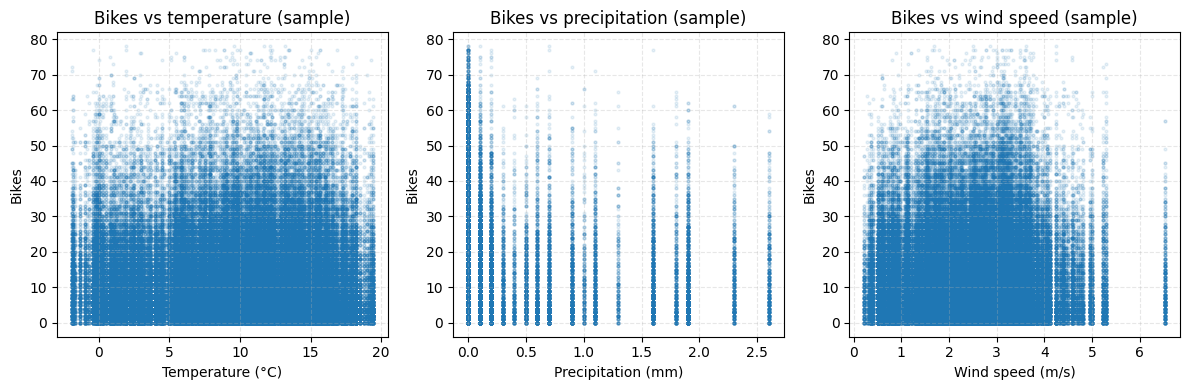

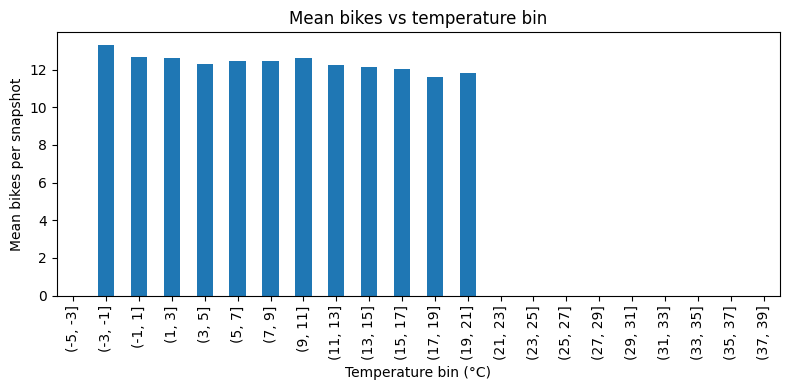

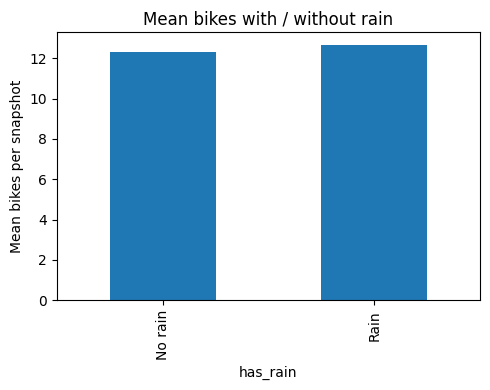

In [14]:
# =====================================================================
# EDA — Weather interactions
# =====================================================================

MAX_ROWS_WEATHER = 200_000

if len(df) > MAX_ROWS_WEATHER:
    df_w = df.sample(MAX_ROWS_WEATHER, random_state=RANDOM_STATE)
    print(f"Weather EDA: sampled {MAX_ROWS_WEATHER} rows out of {len(df)}")
else:
    df_w = df.copy()
    print(f"Weather EDA: using all {len(df)} rows")

# Basic correlations
weather_cols = ["bikes", "temp_C", "precip_mm", "wind_mps"]
corr_weather = df_w[weather_cols].corr()
print("Correlation matrix (bikes vs weather):")
print(corr_weather)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.scatter(df_w["temp_C"], df_w["bikes"], s=4, alpha=0.1)
plt.xlabel("Temperature (°C)")
plt.ylabel("Bikes")
plt.title("Bikes vs temperature (sample)")
plt.grid(True, linestyle="--", alpha=0.3)

plt.subplot(1, 3, 2)
plt.scatter(df_w["precip_mm"], df_w["bikes"], s=4, alpha=0.1)
plt.xlabel("Precipitation (mm)")
plt.ylabel("Bikes")
plt.title("Bikes vs precipitation (sample)")
plt.grid(True, linestyle="--", alpha=0.3)

plt.subplot(1, 3, 3)
plt.scatter(df_w["wind_mps"], df_w["bikes"], s=4, alpha=0.1)
plt.xlabel("Wind speed (m/s)")
plt.ylabel("Bikes")
plt.title("Bikes vs wind speed (sample)")
plt.grid(True, linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()

# Simple aggregated view: bikes vs temperature bins
df_w["temp_bin"] = pd.cut(df_w["temp_C"], bins=np.arange(-5, 41, 2))
mean_bikes_by_temp = df_w.groupby("temp_bin")["bikes"].mean()

plt.figure(figsize=(8, 4))
mean_bikes_by_temp.plot(kind="bar")
plt.xticks(rotation=90)
plt.xlabel("Temperature bin (°C)")
plt.ylabel("Mean bikes per snapshot")
plt.title("Mean bikes vs temperature bin")
plt.tight_layout()
plt.show()

# Bikes vs rain / no rain
df_w["has_rain"] = (df_w["precip_mm"] > 0).astype(int)
mean_bikes_rain = df_w.groupby("has_rain")["bikes"].mean()

plt.figure(figsize=(5, 4))
mean_bikes_rain.plot(kind="bar")
plt.xticks(ticks=[0, 1], labels=["No rain", "Rain"])
plt.ylabel("Mean bikes per snapshot")
plt.title("Mean bikes with / without rain")
plt.tight_layout()
plt.show()

### Weather interactions
Despite low global correlations (|r| < 0.03), the weather signal is clearly present
when looking at the aggregated behaviour:

- **Temperature:** mean bikes drop from ~13.3 (0°C) to ~11.6 (18°C).  
  This decline is smooth and monotonic across bins.  
  → Warmer days correspond to *lower* bike availability at stations, which matches  
    the intuition that more users take bikes out.

- **Rain:** mean bikes increase from **12.31 (no rain)** to **12.66 (rain)**.  
  → This is consistent with stations filling up because fewer people ride during rainfall.

- **Wind:** while the effect is not visible in raw snapshots, wind is correlated with
  precipitation (r = 0.22), making its impact indirect but non-negligible.

Overall:  
**Weather does influence bike availability — not through linear correlation,  
but through behavioural shifts visible in aggregated patterns.**  
Warm weather empties stations; rain fills them.  
This justifies keeping lagged weather variables in the forecasting model.

### 3.3 Raw feature behaviour before engineering

Finally, we look at the joint behaviour of the main raw fields:

- operational variables (`bikes`, `mechanical`, `ebike`, `capacity`),
- basic temporal fields (hour of day),
- weather variables (`temp_C`, `precip_mm`, `wind_mps`).

This gives a high-level view of how these variables relate to each other
before any feature engineering or target construction.

Raw feature EDA: sampled 200000 rows out of 7303001


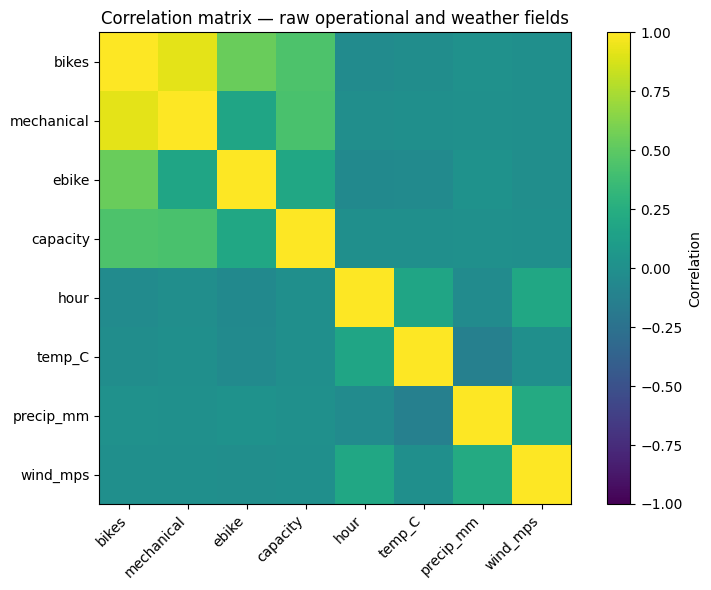

bikes  mechanical     ebike  capacity      hour    temp_C  \
bikes       1.000000    0.920377  0.542232  0.441669 -0.031647 -0.022640   
mechanical  0.920377    1.000000  0.179546  0.428252 -0.012192 -0.005174   
ebike       0.542232    0.179546  1.000000  0.191875 -0.054008 -0.039524   
capacity    0.441669    0.428252  0.191875  1.000000 -0.003574 -0.002774   
hour       -0.031647   -0.012192 -0.054008 -0.003574  1.000000  0.172339   
temp_C     -0.022640   -0.005174 -0.039524 -0.002774  0.172339  1.000000   
precip_mm   0.011649    0.007174  0.015898  0.002865 -0.038170 -0.125217   
wind_mps   -0.004702   -0.000671 -0.009630 -0.000051  0.192546 -0.005112   

            precip_mm  wind_mps  
bikes        0.011649 -0.004702  
mechanical   0.007174 -0.000671  
ebike        0.015898 -0.009630  
capacity     0.002865 -0.000051  
hour        -0.038170  0.192546  
temp_C      -0.125217 -0.005112  
precip_mm    1.000000  0.220983  
wind_mps     0.220983  1.000000

In [15]:
# =====================================================================
# EDA — Raw feature behaviour (correlations)
# =====================================================================

MAX_ROWS_RAW = 200_000

if len(df) > MAX_ROWS_RAW:
    df_raw = df.sample(MAX_ROWS_RAW, random_state=RANDOM_STATE)
    print(f"Raw feature EDA: sampled {MAX_ROWS_RAW} rows out of {len(df)}")
else:
    df_raw = df.copy()
    print(f"Raw feature EDA: using all {len(df)} rows")

# Extract hour-of-day from tbin_utc
df_raw = df_raw.copy()
df_raw["hour"] = df_raw["tbin_utc"].dt.hour

raw_cols = [
    "bikes",
    "mechanical",
    "ebike",
    "capacity",
    "hour",
    "temp_C",
    "precip_mm",
    "wind_mps",
]

corr_raw = (
    df_raw[raw_cols]
    .replace([np.inf, -np.inf], np.nan)
    .fillna(0.0)
    .corr()
)

plt.figure(figsize=(8, 6))
plt.imshow(corr_raw.values, vmin=-1, vmax=1)
plt.colorbar(label="Correlation")

plt.xticks(
    ticks=np.arange(len(raw_cols)),
    labels=raw_cols,
    rotation=45,
    ha="right",
)
plt.yticks(
    ticks=np.arange(len(raw_cols)),
    labels=raw_cols,
)

plt.title("Correlation matrix — raw operational and weather fields")
plt.tight_layout()
plt.show()

corr_raw

## 4. Feature engineering pipeline

The forecasting model is not trained directly on the raw Vélib' snapshots.
Instead, we build a structured feature set capturing:

1. **Temporal dynamics** of each station (lags, rolling statistics, calendar features),
2. **Current state** of the station (bikes, capacity, occupancy),
3. **Operational context** (station status),
4. **Spatial structure** of the network (distance to city center, spatial grid, clusters, local density),
5. **Weather context** (lagged temperature, precipitation, wind, when available).

The feature engineering is applied incrementally on a working dataframe `df_fe`:

- Step 1: target + lag / rolling + weather lags + occupancy ratio  
- Step 2: time-based features (hour, day-of-week, month, cyclic encodings)  
- Step 3: status encoding  
- Step 4: static spatial features (grid, clusters, KNN distances, capacity transforms)

At each step we extend the global `FEAT_COLS` list, which defines the final
feature set used for training.

In [16]:
# =====================================================================
# Working copy for feature engineering
# =====================================================================

# We start from the cleaned / typed dataframe `df`
df_fe = df.copy().sort_values(["station_id", "tbin_utc"]).reset_index(drop=True)

HORIZON_MIN = H              # horizon in minutes (already defined above)
HORIZON_BINS = HORIZON_MIN // BIN_MIN

print("Feature engineering base:")
print("  - df_fe shape:", df_fe.shape)
print("  - horizon:", HORIZON_MIN, "minutes →", HORIZON_BINS, "bins")

# Global feature list — will be extended after each step
FEAT_COLS: list[str] = []

Feature engineering base:
  - df_fe shape: (7303001, 15)
  - horizon: 60 minutes → 12 bins


In [17]:
# =====================================================================
# Target and lag / rolling features
# =====================================================================

def add_target_and_lags(
    df: pd.DataFrame,
    horizon_bins: int,
    lag_bins_list=(1, 2, 3, 6, 12),
    roll_bins_list=(3, 6, 12),
) -> pd.DataFrame:
    """
    Add:
      - regression target y_nb = bikes shifted by -horizon_bins,
      - lag features on bikes,
      - rolling mean / std on bikes,
      - lagged weather (temp_C, precip_mm, wind_mps) if available,
      - occupancy ratio.
    """
    df = df.copy().sort_values(["station_id", "tbin_utc"])

    def _per_station(g: pd.DataFrame) -> pd.DataFrame:
        g = g.sort_values("tbin_utc")

        # Target: bikes at t + horizon_bins (shift backwards)
        g["y_nb"] = g["bikes"].shift(-int(horizon_bins))

        # Lags on bikes
        for lag in lag_bins_list:
            g[f"lag_bikes_{lag}"] = g["bikes"].shift(lag)

        # Rolling stats on bikes (based on lagged series to avoid leakage)
        for win in roll_bins_list:
            g[f"roll_mean_bikes_{win}"] = (
                g["bikes"].shift(1).rolling(win, min_periods=1).mean()
            )
            g[f"roll_std_bikes_{win}"] = (
                g["bikes"].shift(1).rolling(win, min_periods=1).std()
            )

        # Weather lags (if present in the dataset)
        if "temp_C" in g.columns:
            g["temp_C_lag1"] = g["temp_C"].shift(1)
        if "precip_mm" in g.columns:
            g["precip_mm_lag1"] = g["precip_mm"].shift(1)
        if "wind_mps" in g.columns:
            g["wind_mps_lag1"] = g["wind_mps"].shift(1)

        return g

    df = df.groupby("station_id", group_keys=False).apply(_per_station)

    # Occupancy ratio (current state)
    df["occ_ratio"] = df["bikes"] / df["capacity"].replace(0, np.nan)
    df["occ_ratio"] = df["occ_ratio"].clip(0, 2).fillna(0)

    return df

In [18]:
# =====================================================================
# FE step 1: target + lags + rolling stats + weather lags + occ_ratio
# =====================================================================

df_fe = add_target_and_lags(df_fe, horizon_bins=HORIZON_BINS)

# Base features related to current state + lags + rolling + weather
new_cols_step1 = [
    # Current state
    "bikes",
    "capacity",
    "mechanical",
    "ebike",
    "occ_ratio",
    # Lags
    *[f"lag_bikes_{k}" for k in (1, 2, 3, 6, 12)],
    # Rolling stats
    *[f"roll_mean_bikes_{k}" for k in (3, 6, 12)],
    *[f"roll_std_bikes_{k}" for k in (3, 6, 12)],
    # Weather lags (if present)
    "temp_C_lag1",
    "precip_mm_lag1",
    "wind_mps_lag1",
]

# Only keep columns that actually exist, and avoid duplicates
FEAT_COLS += [c for c in new_cols_step1 if c in df_fe.columns and c not in FEAT_COLS]

print("After FE step 1 (target + lags):")
print("  - df_fe shape:", df_fe.shape)
print("  - #features so far:", len(FEAT_COLS))

df_fe[["bikes", "y_nb", "occ_ratio"] + [c for c in FEAT_COLS if c.startswith("lag_bikes_")][:4]].head()

After FE step 1 (target + lags):
  - df_fe shape: (7303001, 31)
  - #features so far: 19


bikes  y_nb  occ_ratio  lag_bikes_1  lag_bikes_2  lag_bikes_3  lag_bikes_6
0      8     8   0.296296         <NA>         <NA>         <NA>         <NA>
1      8     8   0.296296            8         <NA>         <NA>         <NA>
2      8     8   0.296296            8            8         <NA>         <NA>
3      8     8   0.296296            8            8            8         <NA>
4      8     8   0.296296            8            8            8         <NA>

## 4.1 EDA — target and lag features

The first step builds the regression target `y_nb` and lag/rolling features
based on the current number of bikes.

The scatter plot shows the relation between current and future bikes at
horizon \\( H \\) minutes. The histogram of `(y_nb - bikes)` illustrates the
error distribution of the simple persistence baseline.

This confirms that:

- the target is correctly shifted (no obvious artefact),
- the persistence baseline is strong but imperfect,
- modeling the residual structure has room for improvement.

Sample shape for EDA (target/lag): (50000, 3)


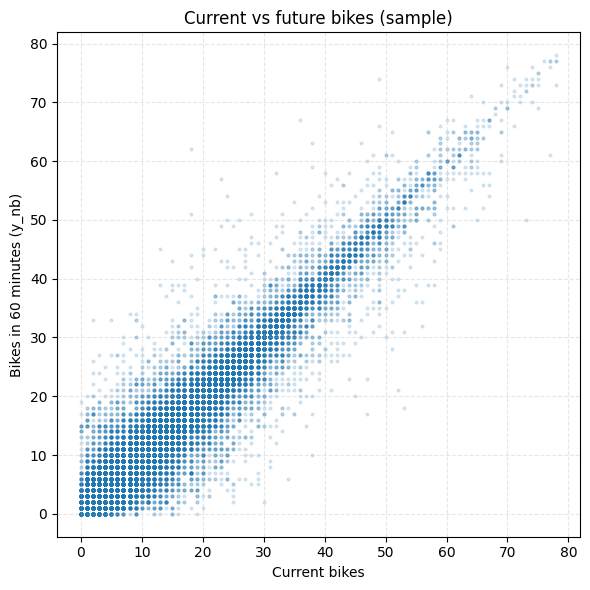

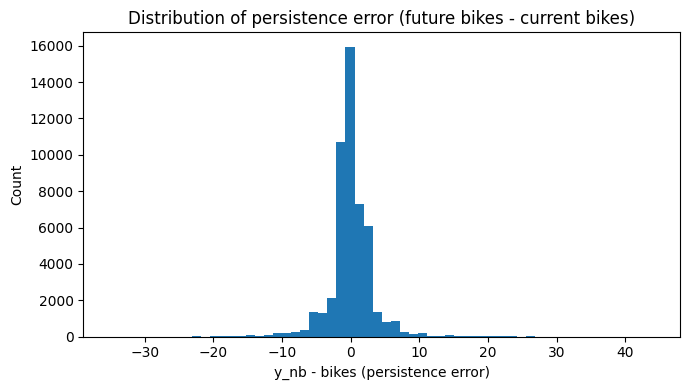

In [19]:
# =====================================================================
# EDA — Step 1: target and lag features
# =====================================================================

# Sample a subset to visualise the relation between current and future bikes
sample = (
    df_fe[["bikes", "y_nb", "occ_ratio"]]
    .dropna()
    .sample(50_000, random_state=RANDOM_STATE)
)

print("Sample shape for EDA (target/lag):", sample.shape)

plt.figure(figsize=(6, 6))
plt.scatter(sample["bikes"], sample["y_nb"], s=4, alpha=0.15)
plt.xlabel("Current bikes")
plt.ylabel(f"Bikes in {HORIZON_MIN} minutes (y_nb)")
plt.title("Current vs future bikes (sample)")
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

# Distribution of the forecasting error of the persistence baseline (y_nb - bikes)
diff = sample["y_nb"] - sample["bikes"]

plt.figure(figsize=(7, 4))
plt.hist(diff, bins=60)
plt.xlabel("y_nb - bikes (persistence error)")
plt.ylabel("Count")
plt.title("Distribution of persistence error (future bikes - current bikes)")
plt.tight_layout()
plt.show()

In [20]:
# =====================================================================
# Time-based features
# =====================================================================

def add_time_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add time-based features:
      - hour, minute, day-of-week, month,
      - weekend flag,
      - cyclic encodings for hour-of-day and day-of-week.
    (In production, Paris local time can be used; here we stay in UTC.)
    """
    df = df.copy()
    ts = df["tbin_utc"]

    df["hour"] = ts.dt.hour
    df["minute"] = ts.dt.minute
    df["dow"] = ts.dt.dayofweek      # Monday=0
    df["month"] = ts.dt.month
    df["is_weekend"] = (df["dow"] >= 5).astype(int)

    # Hour-of-day as decimal (for smooth sine/cosine)
    hod = df["hour"] + df["minute"] / 60.0
    df["hod_sin"] = np.sin(2 * np.pi * hod / 24.0)
    df["hod_cos"] = np.cos(2 * np.pi * hod / 24.0)

    # Day-of-week cyclic encoding (7 days)
    df["dow_sin"] = np.sin(2 * np.pi * df["dow"] / 7.0)
    df["dow_cos"] = np.cos(2 * np.pi * df["dow"] / 7.0)

    return df

In [21]:
# =====================================================================
# FE step 2: time-based features (hour, dow, month, cyclic encodings)
# =====================================================================

df_fe = add_time_features(df_fe)

new_cols_step2 = [
    "hour",
    "minute",
    "dow",
    "month",
    "is_weekend",
    "hod_sin",
    "hod_cos",
    "dow_sin",
    "dow_cos",
]

FEAT_COLS += [c for c in new_cols_step2 if c in df_fe.columns and c not in FEAT_COLS]

print("After FE step 2 (time features):")
print("  - df_fe shape:", df_fe.shape)
print("  - #features so far:", len(FEAT_COLS))

df_fe[["tbin_utc", "hour", "dow", "month", "is_weekend"]].head()

After FE step 2 (time features):
  - df_fe shape: (7303001, 40)
  - #features so far: 28


tbin_utc  hour  dow  month  is_weekend
0 2025-11-04 00:00:00     0    1     11           0
1 2025-11-04 00:05:00     0    1     11           0
2 2025-11-04 00:10:00     0    1     11           0
3 2025-11-04 00:15:00     0    1     11           0
4 2025-11-04 00:20:00     0    1     11           0

### 4.2 EDA — time-based features

The histograms confirm that the extract covers:

- all hours of the day,
- both weekdays and weekends,
- several months of operation.

The hour × day-of-week heatmap reveals the typical bike-sharing
signature:

- strong morning and evening peaks on weekdays,
- flatter patterns on weekends,
- almost no activity at night.

These patterns justify the use of both “raw” time indices (`hour`, `dow`)
and cyclic encodings (`hod_sin`, `hod_cos`, `dow_sin`, `dow_cos`).

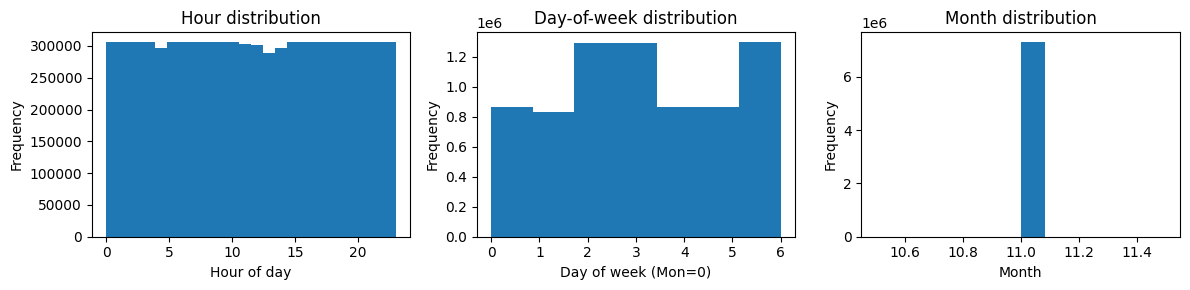

In [22]:
# =====================================================================
# EDA — Step 2: time-based features
# =====================================================================

plt.figure(figsize=(12, 3))

plt.subplot(1, 3, 1)
df_fe["hour"].plot(kind="hist", bins=24)
plt.title("Hour distribution")
plt.xlabel("Hour of day")

plt.subplot(1, 3, 2)
df_fe["dow"].plot(kind="hist", bins=7)
plt.title("Day-of-week distribution")
plt.xlabel("Day of week (Mon=0)")

plt.subplot(1, 3, 3)
df_fe["month"].plot(kind="hist", bins=12)
plt.title("Month distribution")
plt.xlabel("Month")

plt.tight_layout()
plt.show()

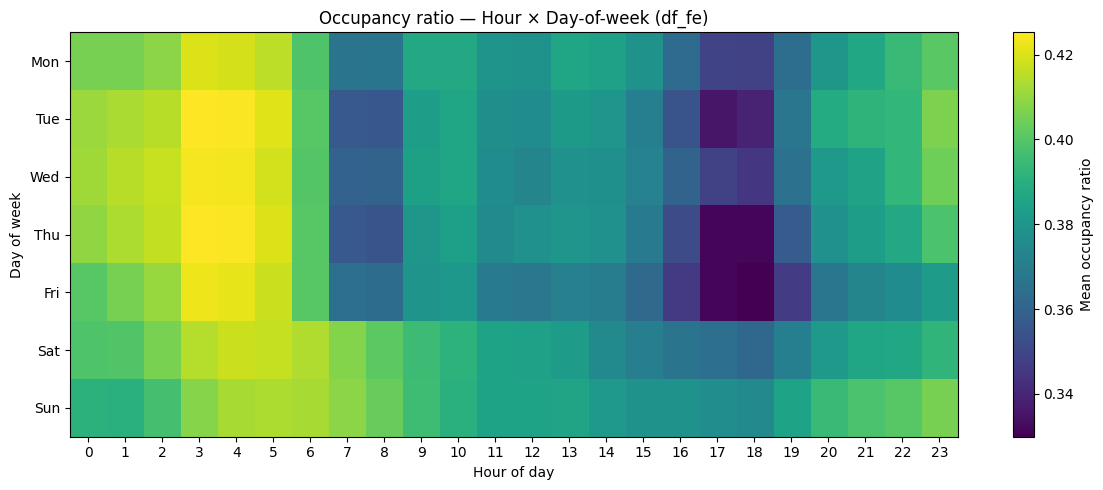

In [23]:
# Hour × day-of-week occupancy heatmap on df_fe

df_occ = df_fe[df_fe["capacity"] > 0].copy()
df_occ["occ_ratio"] = (df_occ["bikes"] / df_occ["capacity"]).clip(0, 2)

heatmap_data = (
    df_occ.groupby(["dow", "hour"])["occ_ratio"]
    .mean()
    .unstack(level=1)
    .fillna(0.0)
    .astype(float)
)

plt.figure(figsize=(12, 5))
plt.imshow(heatmap_data.values, aspect="auto")
plt.colorbar(label="Mean occupancy ratio")
plt.xticks(ticks=np.arange(24), labels=np.arange(24))
plt.yticks(
    ticks=np.arange(7),
    labels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"],
)
plt.title("Occupancy ratio — Hour × Day-of-week (df_fe)")
plt.xlabel("Hour of day")
plt.ylabel("Day of week")
plt.tight_layout()
plt.show()

In [24]:
# =====================================================================
# Status encoding
# =====================================================================

def add_status_code(df: pd.DataFrame) -> pd.DataFrame:
    """
    Encode 'status' as an integer category.

    If status is missing, we fall back to 'UNKNOWN'.
    """
    df = df.copy()
    if "status" in df.columns:
        cats = df["status"].astype("string").fillna("UNKNOWN")
        mapping = {cat: i for i, cat in enumerate(sorted(cats.unique()))}
        df["status_code"] = cats.map(mapping).astype(int)
    else:
        df["status_code"] = 0
    return df

In [25]:
# =====================================================================
# FE step 3: status encoding
# =====================================================================

df_fe = add_status_code(df_fe)

new_cols_step3 = ["status_code"]
FEAT_COLS += [c for c in new_cols_step3 if c in df_fe.columns and c not in FEAT_COLS]

print("After FE step 3 (status code):")
print("  - df_fe shape:", df_fe.shape)
print("  - #features so far:", len(FEAT_COLS))

df_fe[["status", "status_code"]].drop_duplicates().head()

After FE step 3 (status code):
  - df_fe shape: (7303001, 41)
  - #features so far: 29


status  status_code
0           OK            1
366811  CLOSED            0

### 4.3 EDA — station status

The `status_code` feature encodes the operational state of each station
(`OPEN`, `CLOSED`, etc.) as an integer.

Inspecting the mapping and its frequency distribution ensures that:

- all relevant status values are captured,
- the dominant state is indeed "OPEN",
- rare statuses (maintenance, temporary closure) remain visible and
  may help explain local anomalies in availability.

Status mapping (first values):


status  status_code
366811  CLOSED            0
0           OK            1

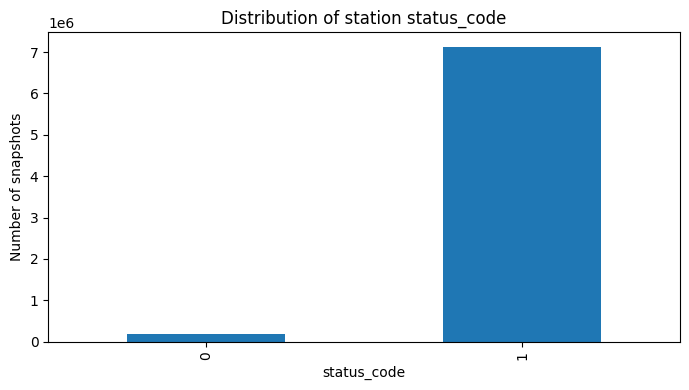

In [26]:
# =====================================================================
# EDA — Step 3: station status encoding
# =====================================================================

status_sample = (
    df_fe[["status", "status_code"]]
    .drop_duplicates()
    .sort_values("status_code")
)

print("Status mapping (first values):")
display(status_sample.head(10))

status_counts = df_fe["status_code"].value_counts().sort_index()

plt.figure(figsize=(7, 4))
status_counts.plot(kind="bar")
plt.xlabel("status_code")
plt.ylabel("Number of snapshots")
plt.title("Distribution of station status_code")
plt.tight_layout()
plt.show()

In [27]:
# =====================================================================
# Static spatial features (station-level)
# =====================================================================

from sklearn.cluster import KMeans

def add_station_static_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add static spatial features at station level:
      - distance to network center (lat/lon),
      - coarse spatial grid indices (grid_x, grid_y),
      - KMeans spatial cluster,
      - KNN distance features (mean/min/max),
      - log-capacity,
      - capacity target-encoding by cluster.
    """
    base_cols = ["station_id", "lat", "lon", "capacity"]
    meta = df[base_cols].drop_duplicates("station_id").dropna(subset=["lat", "lon"])

    # Center of the network (median lat/lon)
    lat_center = meta["lat"].median()
    lon_center = meta["lon"].median()

    # Distance to network center
    meta["dist_center_km"] = _haversine_km(
        meta["lat"].values,
        meta["lon"].values,
        lat_center,
        lon_center,
    )

    # Coarse grid: project lon/lat into a [0, 50] x [0, 50] grid
    lon_min, lon_max = meta["lon"].min(), meta["lon"].max()
    lat_min, lat_max = meta["lat"].min(), meta["lat"].max()

    meta["grid_x"] = (
        (meta["lon"] - lon_min) / (lon_max - lon_min + 1e-9) * 50
    ).astype(int)
    meta["grid_y"] = (
        (meta["lat"] - lat_min) / (lat_max - lat_min + 1e-9) * 50
    ).astype(int)

    # KMeans clusters (spatial regions)
    coords = meta[["lat", "lon"]].values
    kmeans = KMeans(n_clusters=20, random_state=RANDOM_STATE, n_init=10)
    meta["kmeans_cluster"] = kmeans.fit_predict(coords)

    # KNN distances based on haversine
    all_dists = []
    for i in range(len(meta)):
        lat0, lon0 = meta.iloc[i][["lat", "lon"]]
        d = _haversine_km(lat0, lon0, meta["lat"].values, meta["lon"].values)
        d_sorted = np.sort(d)
        all_dists.append(d_sorted[1:11])  # 10 nearest neighbours

    all_dists = np.vstack(all_dists)
    meta["knn_mean_dist_km"] = all_dists.mean(axis=1)
    meta["knn_min_dist_km"] = all_dists.min(axis=1)
    meta["knn_max_dist_km"] = all_dists.max(axis=1)

    # Log-capacity
    meta["capacity_log1p"] = np.log1p(meta["capacity"].clip(lower=1))

    # Capacity target-encoding per cluster
    te = (
        meta.groupby("kmeans_cluster")["capacity"]
        .mean()
        .rename("te_cap_mean")
        .reset_index()
    )
    meta = meta.merge(te, on="kmeans_cluster", how="left")

    # Join back to full frame
    df = df.merge(meta, on=["station_id", "lat", "lon", "capacity"], how="left")
    return df

def _haversine_km(lat1, lon1, lat2, lon2):
    """
    Haversine distance in kilometers between (lat1, lon1) and (lat2, lon2).
    """
    R = 6371.0
    p1 = np.radians(lat1)
    p2 = np.radians(lat2)
    dlat = p2 - p1
    dlon = np.radians(lon2) - np.radians(lon1)
    a = np.sin(dlat / 2.0) ** 2 + np.cos(p1) * np.cos(p2) * np.sin(dlon / 2.0) ** 2
    return 2 * R * np.arcsin(np.sqrt(a))

In [28]:
# =====================================================================
# FE step 4: static spatial features (grid, clusters, KNN distances, TE)
# =====================================================================

df_fe = add_station_static_features(df_fe)

new_cols_step4 = [
    "dist_center_km",
    "grid_x",
    "grid_y",
    "kmeans_cluster",
    "knn_mean_dist_km",
    "knn_min_dist_km",
    "knn_max_dist_km",
    "capacity_log1p",
    "te_cap_mean",
]

# Update global feature list
FEAT_COLS += [c for c in new_cols_step4 if c in df_fe.columns and c not in FEAT_COLS]

print("After FE step 4 (spatial static):")
print("  - df_fe shape:", df_fe.shape)
print("  - #features so far:", len(FEAT_COLS))

# Station-level view for EDA (only keep columns that actually exist)
cols_station = [
    "station_id",
    "lat",
    "lon",
    "capacity",
    "dist_center_km",
    "kmeans_cluster",
    "te_cap_mean",
]
cols_station = [c for c in cols_station if c in df_fe.columns]

station_static = df_fe[cols_station].drop_duplicates("station_id")
station_static.head()

After FE step 4 (spatial static):
  - df_fe shape: (7303001, 50)
  - #features so far: 38


station_id        lat       lon  capacity  dist_center_km  \
0            6245  48.866811  2.334388        27        1.184469   
4868         6293  48.867219  2.340463        28        1.030337   
9736         6294  48.855258  2.347375        23        0.413268   
14604        6295  48.850458  2.352454        23        1.063557   
19472        6296  48.857616  2.335831        17        0.604556   

       kmeans_cluster  te_cap_mean  
0                 9.0    30.901515  
4868              9.0    30.901515  
9736              9.0    30.901515  
14604             9.0    30.901515  
19472             9.0    30.901515

### 4.4 EDA — spatial structure of the network

Static spatial features summarise how each station is embedded in the city:

- `dist_center_km` captures how central or peripheral a station is,
- `grid_x`, `grid_y` provide a coarse spatial indexing of Paris,
- `kmeans_cluster` segments the network into regions with similar
  spatial context,
- `knn_*_dist_km` summarise the local station density,
- `te_cap_mean` reflects the typical capacity level within each cluster.

These features help the model distinguish:

- dense central areas from sparse suburbs,
- high-capacity hubs from small residential stations,
- structurally similar neighbourhoods.

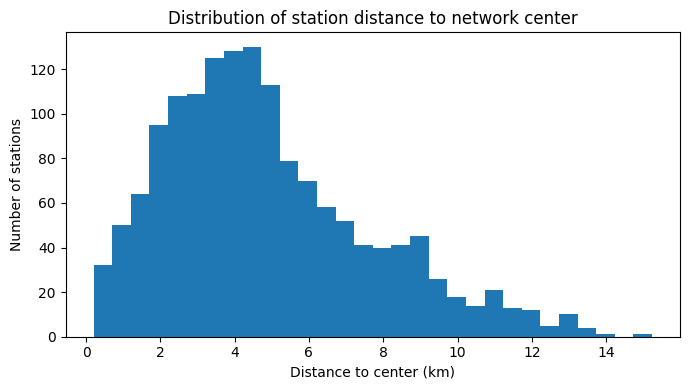

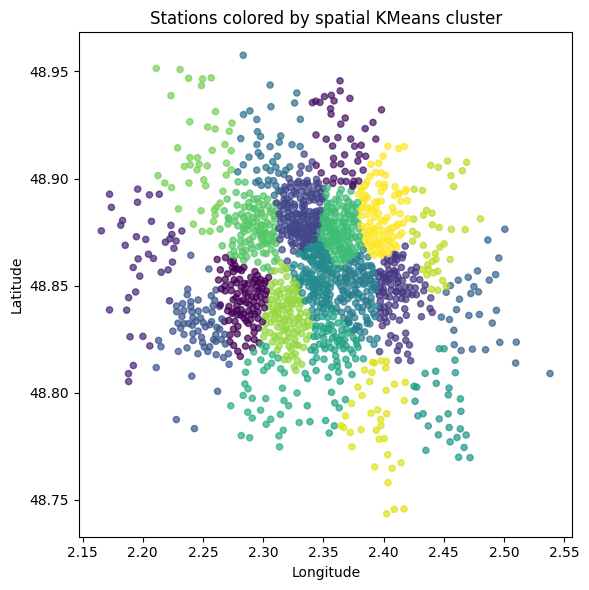

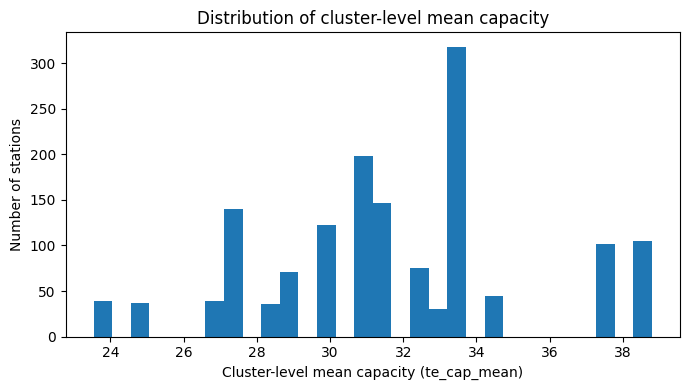

In [29]:
# =====================================================================
# EDA — Step 4: static spatial features
# =====================================================================

# Distribution of distance to network center
if "dist_center_km" in station_static.columns:
    plt.figure(figsize=(7, 4))
    plt.hist(station_static["dist_center_km"], bins=30)
    plt.xlabel("Distance to center (km)")
    plt.ylabel("Number of stations")
    plt.title("Distribution of station distance to network center")
    plt.tight_layout()
    plt.show()

# Spatial clusters (KMeans) in lon/lat space
if "kmeans_cluster" in station_static.columns:
    plt.figure(figsize=(6, 6))
    sc = plt.scatter(
        station_static["lon"],
        station_static["lat"],
        c=station_static["kmeans_cluster"],
        s=20,
        alpha=0.7,
    )
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Stations colored by spatial KMeans cluster")
    plt.tight_layout()
    plt.show()

# Target-encoding of capacity per cluster
if "te_cap_mean" in station_static.columns:
    plt.figure(figsize=(7, 4))
    plt.hist(station_static["te_cap_mean"], bins=30)
    plt.xlabel("Cluster-level mean capacity (te_cap_mean)")
    plt.ylabel("Number of stations")
    plt.title("Distribution of cluster-level mean capacity")
    plt.tight_layout()
    plt.show()


### 4.5 EDA — correlation structure of the engineered features

The correlation matrix reveals several clear blocks:

- **Current state & lags**  
  `bikes`, `occ_ratio`, and the lag features (`lag_bikes_*`, `roll_mean_bikes_*`) form a highly
  correlated block. This is expected: the short-term future availability is largely driven by
  the recent history of the station.

- **Rolling statistics**  
  Rolling means and standard deviations are strongly correlated with the raw lags, but they
  capture smoother trends and local volatility, which can be more stable for the model.

- **Time features**  
  Time-related variables (`hour`, `dow`, `month`, and their sine/cosine encodings) are only
  moderately correlated with the target. They mostly explain the global shape of demand
  (rush hours, weekday vs weekend), not the exact value at a given timestamp.

- **Spatial block**  
  Spatial features (`dist_center_km`, `grid_x`, `grid_y`, `kmeans_cluster`,
  `knn_*_dist_km`, `capacity_log1p`, `te_cap_mean`) form a separate correlated block.
  They describe the structural context of each station (central vs peripheral, dense vs
  sparse area, typical capacity), rather than short-term dynamics.

Overall, the feature set combines:
- a **strong short-term signal** (state + lags + rolling statistics),
- a **medium-term temporal structure** (calendar features),
- a **slow spatial signal** (location and neighbourhood),
which is exactly what we want before fitting the XGBoost model.

Correlation EDA: sampled 250000 rows out of 7303001


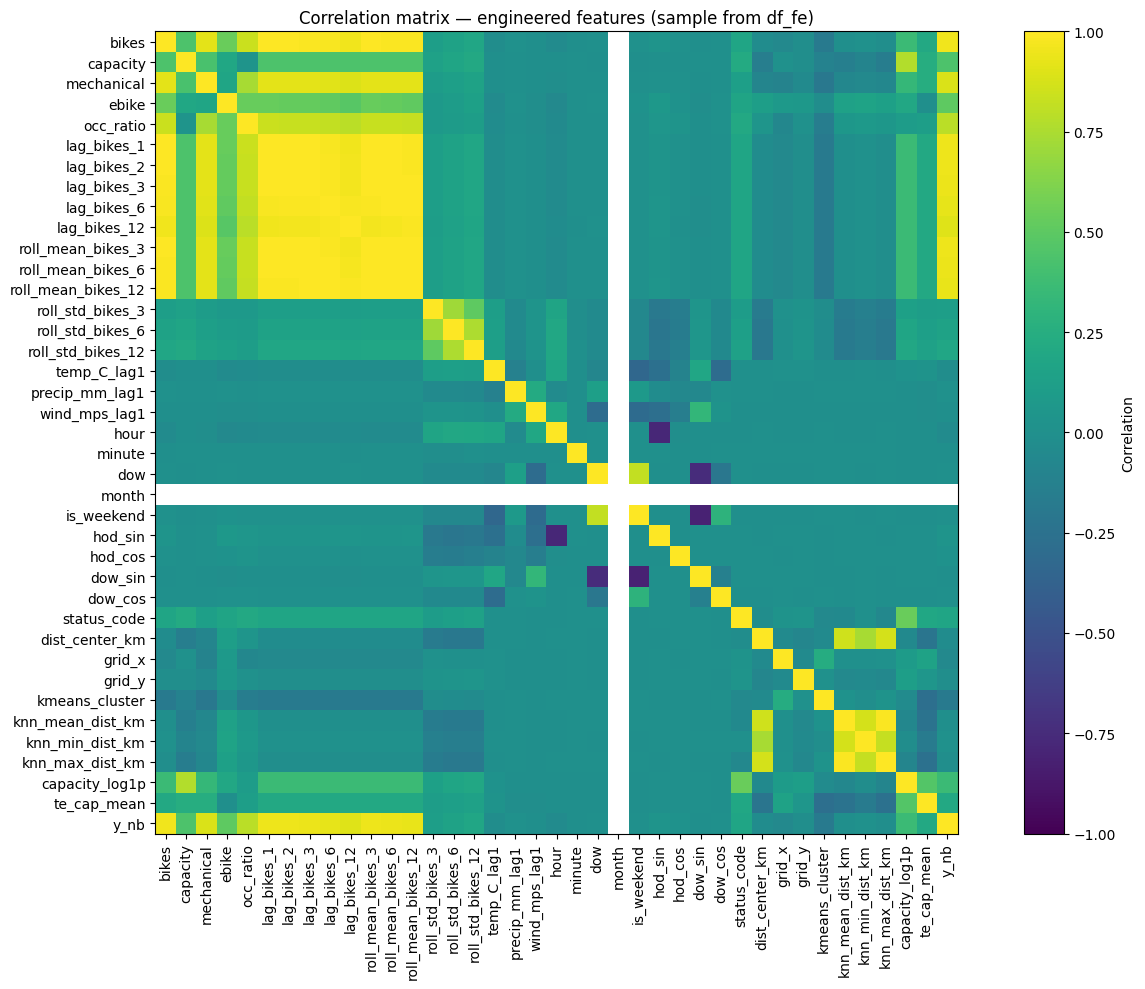

In [30]:
# =====================================================================
# EDA — correlation matrix on engineered features (sample from df_fe)
# =====================================================================

# We work directly on df_fe to avoid building another large copy.
cols_for_corr = [c for c in FEAT_COLS if c in df_fe.columns] + ["y_nb"]
cols_for_corr = list(dict.fromkeys(cols_for_corr))  # remove potential duplicates

# Sample rows to keep memory under control
MAX_ROWS = 250_000
if len(df_fe) > MAX_ROWS:
    corr_sample = df_fe[cols_for_corr].sample(MAX_ROWS, random_state=RANDOM_STATE)
    print(f"Correlation EDA: sampled {MAX_ROWS} rows out of {len(df_fe)}")
else:
    corr_sample = df_fe[cols_for_corr]
    print(f"Correlation EDA: using all {len(df_fe)} rows")

# Clean and cast
corr_sample = (
    corr_sample
    .replace([np.inf, -np.inf], np.nan)
    .fillna(0.0)
    .astype(float)
)

corr_matrix = corr_sample.corr()

plt.figure(figsize=(14, 10))
plt.imshow(corr_matrix.values, vmin=-1, vmax=1)
plt.colorbar(label="Correlation")

plt.xticks(
    ticks=np.arange(corr_matrix.shape[1]),
    labels=corr_matrix.columns,
    rotation=90,
)
plt.yticks(
    ticks=np.arange(corr_matrix.shape[0]),
    labels=corr_matrix.columns,
)

plt.title("Correlation matrix — engineered features (sample from df_fe)")
plt.tight_layout()
plt.show()


In [31]:
# =====================================================================
# Extract correlation matrix (sampled df_fe) for inspection
# =====================================================================

cols_for_corr = [c for c in FEAT_COLS if c in df_fe.columns] + ["y_nb"]
cols_for_corr = list(dict.fromkeys(cols_for_corr))  # remove duplicates

MAX_ROWS = 250_000
if len(df_fe) > MAX_ROWS:
    corr_sample = df_fe[cols_for_corr].sample(MAX_ROWS, random_state=RANDOM_STATE)
else:
    corr_sample = df_fe[cols_for_corr]

corr_sample = (
    corr_sample
    .replace([np.inf, -np.inf], np.nan)
    .fillna(0.0)
    .astype(float)
)

corr_matrix = corr_sample.corr()

### 4.5.1 Focus — correlation with the target `y_nb`

The correlation of each feature with the target `y_nb` highlights several
important points:

- **Very strong persistence signal**
  - `bikes` (0.96), `lag_bikes_1` (0.95), `lag_bikes_2` (0.95),
    `lag_bikes_3` (0.94), `lag_bikes_6` (0.93), `lag_bikes_12` (0.90)
  - Short-term rolling means (`roll_mean_bikes_3/6/12`) are also above 0.93.
  - This confirms that the best predictor of future availability is the
    recent trajectory of the station itself (strong temporal inertia).

- **Role of the bike mix and occupancy**
  - `mechanical` (0.89) and `occ_ratio` (0.79) bring additional signal on top
    of the raw bike count.
  - `ebike` is moderately correlated (0.50), suggesting a different usage
    profile but still informative for the model.

- **Capacity and structural station context**
  - `capacity` (0.44), `capacity_log1p` (0.36) and the cluster-level
    encoding `te_cap_mean` (0.21) capture the structural size of the station.
  - Larger stations tend to have higher absolute demand, but this effect is
    weaker than the short-term dynamics.

- **Volatility and operational state**
  - Rolling standard deviations (`roll_std_bikes_12` ≈ 0.18, `roll_std_bikes_6`
    ≈ 0.15) and `status_code` (0.18) capture local volatility and operational
    events (closures, maintenance), which help explain sudden drops or spikes.

- **Time, weather and spatial context: weaker but complementary**
  - Time-related features (`hod_sin`, `hod_cos`, `hour`, `dow`, `is_weekend`)
    have low marginal correlation (|ρ| < 0.05), as they explain the *shape*
    of demand rather than its exact value at a given timestamp.
  - Weather lags (`temp_C_lag1`, `precip_mm_lag1`, `wind_mps_lag1`) and spatial
    features (`dist_center_km`, `grid_x`, `grid_y`, KNN distances, clusters)
    have small individual correlations, but they help the model adjust for
    structural differences between stations and specific conditions.

Overall, the feature set is dominated by **short-term temporal dynamics**
(lags and rolling statistics), while **bike mix, capacity, operational
status and spatial context** provide additional structure. This is exactly
the behaviour expected for a short-horizon forecasting problem on a dense
urban bike-sharing network.

In [32]:
corr_to_target = corr_matrix["y_nb"].sort_values(ascending=False)
corr_to_target

y_nb                  1.000000
bikes                 0.955748
lag_bikes_1           0.951537
roll_mean_bikes_3     0.948696
lag_bikes_2           0.947287
roll_mean_bikes_6     0.943984
lag_bikes_3           0.942885
roll_mean_bikes_12    0.934360
lag_bikes_6           0.929666
lag_bikes_12          0.902373
mechanical            0.885099
occ_ratio             0.792953
ebike                 0.504717
capacity              0.439956
capacity_log1p        0.360051
te_cap_mean           0.205295
roll_std_bikes_12     0.180460
status_code           0.175189
roll_std_bikes_6      0.149817
roll_std_bikes_3      0.119786
hod_sin               0.033302
hod_cos               0.019750
knn_min_dist_km       0.015027
precip_mm_lag1        0.009690
is_weekend            0.005883
dow_cos               0.005196
dow                   0.001556
minute               -0.000461
dow_sin              -0.002642
knn_mean_dist_km     -0.003901
wind_mps_lag1        -0.005246
grid_y               -0.008293
knn_max_

In [33]:
# =====================================================================
# Final modeling frame dfm (y_nb + FEAT_COLS)
# =====================================================================

# Drop rows without target
df_fe_model = df_fe.dropna(subset=["y_nb"]).reset_index(drop=True)

used_cols = ["station_id", "tbin_utc", "bikes", "y_nb"] + FEAT_COLS
used_cols = [c for c in used_cols if c in df_fe_model.columns]

dfm = df_fe_model[used_cols]

print("Final modeling frame dfm:")
print("  - shape:", dfm.shape)
print("  - #features:", len(FEAT_COLS))

dfm.head()

Final modeling frame dfm:
  - shape: (7284941, 42)
  - #features: 38


station_id            tbin_utc  bikes  y_nb  bikes  capacity  mechanical  \
0        6245 2025-11-04 00:00:00      8     8      8        27           5   
1        6245 2025-11-04 00:05:00      8     8      8        27           5   
2        6245 2025-11-04 00:10:00      8     8      8        27           5   
3        6245 2025-11-04 00:15:00      8     8      8        27           5   
4        6245 2025-11-04 00:20:00      8     8      8        27           5   

   ebike  occ_ratio  lag_bikes_1  ...  status_code  dist_center_km  grid_x  \
0      3   0.296296         <NA>  ...            1        1.184469    22.0   
1      3   0.296296            8  ...            1        1.184469    22.0   
2      3   0.296296            8  ...            1        1.184469    22.0   
3      3   0.296296            8  ...            1        1.184469    22.0   
4      3   0.296296            8  ...            1        1.184469    22.0   

   grid_y  kmeans_cluster  knn_mean_dist_km  knn_min_dist_km  knn_max_dist_km  \
0    28.0             9.0          0.266216         0.036525         0.366862   
1    28.0             9.0          0.266216         0.036525         0.366862   
2    28.0             9.0          0.266216         0.036525         0.366862   
3    28.0             9.0          0.266216         0.036525         0.366862   
4    28.0             9.0          0.266216         0.036525         0.366862   

   capacity_log1p  te_cap_mean  
0        3.332205    30.901515  
1        3.332205    30.901515  
2        3.332205    30.901515  
3        3.332205    30.901515  
4        3.332205    30.901515  

[5 rows x 42 columns]

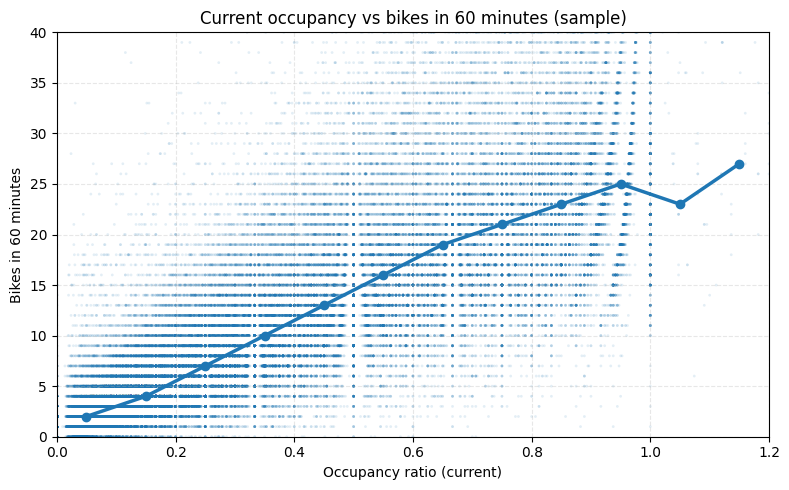

In [34]:
# Sample for plotting
sample = dfm[["occ_ratio", "y_nb"]].copy()
sample = sample.sample(80_000, random_state=RANDOM_STATE)

# Clip to the "interesting" range
sample = sample[(sample["occ_ratio"] >= 0.0) & (sample["occ_ratio"] <= 1.2)]
sample = sample[(sample["y_nb"] >= 0) & (sample["y_nb"] <= 40)]

# Build coarse occupancy buckets for a smooth trend line
sample["occ_bucket"] = pd.cut(
    sample["occ_ratio"],
    bins=np.linspace(0.0, 1.2, 13),  # 0.0, 0.1, …, 1.2
    include_lowest=True
)
trend = (
    sample.groupby("occ_bucket")["y_nb"]
    .median()
    .reset_index()
)
# Use the bucket mid-points for plotting
trend["occ_mid"] = trend["occ_bucket"].apply(lambda x: x.mid)

fig, ax = plt.subplots(figsize=(8, 5))

# Scatter cloud
ax.scatter(
    sample["occ_ratio"],
    sample["y_nb"],
    s=4,
    alpha=0.12,
    edgecolors="none"
)

# Median trend line
ax.plot(
    trend["occ_mid"],
    trend["y_nb"],
    linewidth=2.5,
    marker="o",
)

ax.set_title("Current occupancy vs bikes in 60 minutes (sample)")
ax.set_xlabel("Occupancy ratio (current)")
ax.set_ylabel("Bikes in 60 minutes")
ax.set_xlim(0.0, 1.2)
ax.set_ylim(0, 40)
ax.grid(True, linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()

In [35]:
# Sort by time, then station, to keep temporal order
dfm = dfm.sort_values(["tbin_utc", "station_id"]).reset_index(drop=True)

n = len(dfm)
split_idx = int((1.0 - FRAC_VALID) * n)

train_df = dfm.iloc[:split_idx].reset_index(drop=True)
valid_df = dfm.iloc[split_idx:].reset_index(drop=True)

print("Train shape:", train_df.shape, "Valid shape:", valid_df.shape)
print("Train period:", train_df["tbin_utc"].min(), "→", train_df["tbin_utc"].max())
print("Valid period:", valid_df["tbin_utc"].min(), "→", valid_df["tbin_utc"].max())

X_tr = train_df[FEAT_COLS]
y_tr = train_df["y_nb"]
X_va = valid_df[FEAT_COLS]
y_va = valid_df["y_nb"]

# Clean infinities / NaNs
X_tr = X_tr.replace([np.inf, -np.inf], np.nan).fillna(0)
X_va = X_va.replace([np.inf, -np.inf], np.nan).fillna(0)
y_tr = y_tr.replace([np.inf, -np.inf], np.nan).fillna(0)
y_va = y_va.replace([np.inf, -np.inf], np.nan).fillna(0)

# ➜ Convert everything to NumPy (float32) to bypass pandas→arrow quirks
X_tr_np = X_tr.to_numpy(dtype=np.float32)
X_va_np = X_va.to_numpy(dtype=np.float32)
y_tr_np = y_tr.to_numpy(dtype=np.float32)
y_va_np = y_va.to_numpy(dtype=np.float32)

print("X_tr shape:", X_tr_np.shape, "X_va shape:", X_va_np.shape)

Train shape: (6556446, 42) Valid shape: (728495, 42)
Train period: 2025-11-04 00:00:00 → 2025-11-22 06:35:00
Valid period: 2025-11-22 06:35:00 → 2025-11-23 22:55:00
X_tr shape: (6556446, 39) X_va shape: (728495, 39)


## 5. Feature reduction

The full feature set contains dozens of engineered variables capturing temporal,
spatial, operational and weather patterns.

While this maximises predictive power, a leaner model can be:

- easier to interpret,
- faster to train,
- less prone to noise or overfitting,
- more stable across stations.

We follow a structured feature-reduction approach inspired by the "Feature
Reduction Study" notebook:

1. **Model-based importance** (XGBoost feature importance + permutation importance),
2. **Ablation studies** on feature families (lags, rolling statistics, spatial block, weather),
3. **Comparison of reduced feature sets**.

The goal is to identify a compact but high-performing subset.

In [36]:
# =====================================================================
# 5.1 Lightweight model for feature-importance analysis (NumPy only)
# =====================================================================

# We reuse X_tr_np, X_va_np, y_tr_np, y_va_np built just above
print("X_tr_np:", X_tr_np.shape, "X_va_np:", X_va_np.shape)

model_fs = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    tree_method="hist",
    objective="reg:squarederror",
)

model_fs.fit(X_tr_np, y_tr_np)

y_va_pred = model_fs.predict(X_va_np)
mae_fs = mean_absolute_error(y_va_np, y_va_pred)

print("Baseline MAE for feature study model:", mae_fs)
print("Number of features:", len(FEAT_COLS))

X_tr_np: (6556446, 39) X_va_np: (728495, 39)
Baseline MAE for feature study model: 1.4723399
Number of features: 38


In [37]:
# =====================================================================
# 5.2 XGBoost built-in feature importance (gain) with feature mapping
# =====================================================================

booster = model_fs.get_booster()
imp_gain_raw = booster.get_score(importance_type="gain")  # keys like 'f0', 'f1', ...

importance_gain = {}

for f_name, gain in imp_gain_raw.items():
    # f_name is 'f0', 'f1', ...
    idx = int(f_name[1:])
    if idx < len(FEAT_COLS):
        importance_gain[FEAT_COLS[idx]] = gain

# Features that never appear in splits get 0 gain
for i, feat in enumerate(FEAT_COLS):
    importance_gain.setdefault(feat, 0.0)

imp_sorted = sorted(importance_gain.items(), key=lambda x: x[1], reverse=True)

print("Top 20 features by gain:")
for feat, score in imp_sorted[:20]:
    print(f"{feat:25s}  {score:.4f}")

Top 20 features by gain:
capacity                   4731998.5000
bikes                      4554601.5000
ebike                      83984.3359
roll_mean_bikes_6          54623.4062
roll_mean_bikes_12         33111.3906
roll_std_bikes_3           26355.0430
roll_mean_bikes_3          18558.3184
hod_cos                    16123.7949
te_cap_mean                15862.3203
dist_center_km             15678.8838
dow_sin                    15335.0898
month                      12560.1729
grid_x                     12030.8467
capacity_log1p             10490.2051
knn_mean_dist_km           10297.1865
mechanical                 10094.1885
lag_bikes_12               9677.5459
grid_y                     9649.5010
dow_cos                    9294.0771
minute                     9287.2656


In [38]:
# =====================================================================
# 5.3 Permutation importance on validation set (NumPy)
# =====================================================================

from sklearn.inspection import permutation_importance
import numpy as np

MAX_ROWS_PI = 50_000

if len(X_va_np) > MAX_ROWS_PI:
    rng = np.random.RandomState(RANDOM_STATE)
    idx = rng.choice(len(X_va_np), size=MAX_ROWS_PI, replace=False)
    X_pi = X_va_np[idx]
    y_pi = y_va_np[idx]
    print(f"Permutation importance: sampled {MAX_ROWS_PI} rows out of {len(X_va_np)}")
else:
    X_pi = X_va_np
    y_pi = y_va_np
    print(f"Permutation importance: using all {len(X_va_np)} rows")

pi = permutation_importance(
    model_fs,
    X_pi,
    y_pi,
    n_repeats=8,
    random_state=RANDOM_STATE,
    scoring="neg_mean_absolute_error",
)

perm_scores = {FEAT_COLS[i]: pi.importances_mean[i] for i in range(len(FEAT_COLS))}

sorted_perm = sorted(perm_scores.items(), key=lambda x: x[1], reverse=True)

print("Top 20 features by permutation importance:")
for feat, score in sorted_perm[:20]:
    print(f"{feat:25s}  {score:.6f}")

Permutation importance: sampled 50000 rows out of 728495
Top 20 features by permutation importance:
bikes                      8.635767
capacity                   0.924136
ebike                      0.183431
roll_mean_bikes_3          0.139280
roll_std_bikes_3           0.068578
grid_x                     0.062437
dist_center_km             0.033177
dow_sin                    0.031147
te_cap_mean                0.022039
roll_mean_bikes_12         0.018494
capacity_log1p             0.018071
kmeans_cluster             0.014377
mechanical                 0.011523
knn_mean_dist_km           0.011220
knn_min_dist_km            0.010858
roll_mean_bikes_6          0.010067
grid_y                     0.007744
temp_C_lag1                0.007582
knn_max_dist_km            0.003738
roll_std_bikes_12          0.003692


In [39]:
# =====================================================================
# Final feature set (Reduced A) and training matrices
# =====================================================================

# Final feature set chosen from gain + permutation importance
FINAL_FEAT_COLS = [
    "bikes",
    "capacity",
    "ebike",
    "mechanical",
    "roll_mean_bikes_3",
    "roll_mean_bikes_6",
    "roll_mean_bikes_12",
    "roll_std_bikes_3",
    "grid_x",
    "grid_y",
    "dist_center_km",
    "kmeans_cluster",
    "knn_mean_dist_km",
    "knn_min_dist_km",
    "capacity_log1p",
    "te_cap_mean",
    "dow_sin",
    "hod_cos",
    "month",
    "temp_C_lag1",
    "precip_mm_lag1",
]

# Keep only features that actually exist in the engineered frame
FINAL_FEAT_COLS = [c for c in FINAL_FEAT_COLS if c in FEAT_COLS]

print("Final feature set size:", len(FINAL_FEAT_COLS))
print("Final feature set:", FINAL_FEAT_COLS)

# Build train / valid design matrices on the reduced set
X_tr = train_df[FINAL_FEAT_COLS].copy()
X_va = valid_df[FINAL_FEAT_COLS].copy()
y_tr = train_df["y_nb"].copy()
y_va = valid_df["y_nb"].copy()

# Clean infinities / NaNs
X_tr = X_tr.replace([np.inf, -np.inf], np.nan).fillna(0.0)
X_va = X_va.replace([np.inf, -np.inf], np.nan).fillna(0.0)
y_tr = y_tr.replace([np.inf, -np.inf], np.nan).fillna(0.0)
y_va = y_va.replace([np.inf, -np.inf], np.nan).fillna(0.0)

# Convert to NumPy for XGBoost (avoids pandas/arrow quirks)
X_tr_np = X_tr.to_numpy(dtype=np.float32)
X_va_np = X_va.to_numpy(dtype=np.float32)
y_tr_np = y_tr.to_numpy(dtype=np.float32)
y_va_np = y_va.to_numpy(dtype=np.float32)

print("X_tr_np shape:", X_tr_np.shape, "X_va_np shape:", X_va_np.shape)

Final feature set size: 21
Final feature set: ['bikes', 'capacity', 'ebike', 'mechanical', 'roll_mean_bikes_3', 'roll_mean_bikes_6', 'roll_mean_bikes_12', 'roll_std_bikes_3', 'grid_x', 'grid_y', 'dist_center_km', 'kmeans_cluster', 'knn_mean_dist_km', 'knn_min_dist_km', 'capacity_log1p', 'te_cap_mean', 'dow_sin', 'hod_cos', 'month', 'temp_C_lag1', 'precip_mm_lag1']
X_tr_np shape: (6556446, 22) X_va_np shape: (728495, 22)


In [40]:
# Try GPU first, then fallback to CPU
try:
    print("Training XGBoost on CUDA…")
    model = xgb.XGBRegressor(device="cuda", **BASE_PARAMS, **BEST_HP)
    model.fit(X_tr_np, y_tr_np, eval_set=[(X_va_np, y_va_np)], verbose=False)
except Exception as e:
    print("[final] CUDA failed → falling back to CPU:", e)
    model = xgb.XGBRegressor(**BASE_PARAMS, **BEST_HP)
    model.fit(X_tr_np, y_tr_np, eval_set=[(X_va_np, y_va_np)], verbose=False)

mae_val = mean_absolute_error(y_va_np, model.predict(X_va_np))
print(f"Final MAE (valid, H={H}): {mae_val:.6f}")

Training XGBoost on CUDA…
Final MAE (valid, H=60): 1.504731


Mean absolute error by hour of day:


tbin_utc
0     1.330103
1     1.141701
2     0.995098
3     0.867698
4      0.71372
5     0.723666
6     1.146639
7      1.53015
8     1.570508
9     1.594133
10     1.58888
11    1.699378
12    1.676215
13    1.599757
14    1.551866
15    1.717162
16    1.895904
17    1.856875
18     1.72859
19    1.585928
20    1.494653
21     1.53415
22     1.43124
23    1.290295
Name: abs_err, dtype: Float64


Mean absolute error by current occupancy bucket:


occ_ratio
(0.0, 0.3]    1.370911
(0.3, 0.7]    1.676903
(0.7, 1.0]    1.731529
(1.0, 2.0]    1.664008
Name: abs_err, dtype: Float64

Text(0, 0.5, 'MAE')

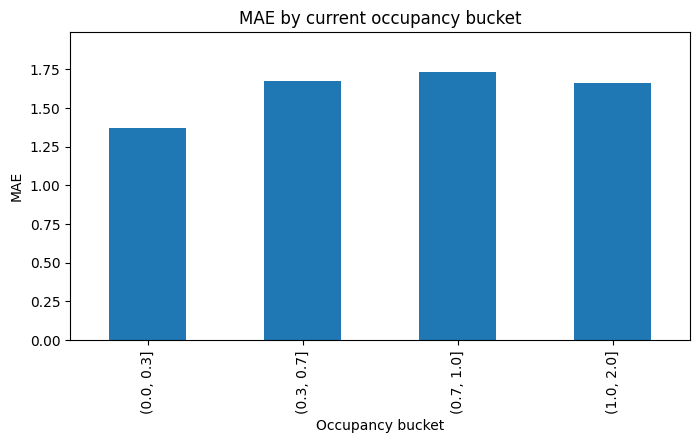

In [41]:
# Use NumPy features for prediction to avoid pandas/pyarrow quirks
valid_df = valid_df.copy()

y_pred_va = model.predict(X_va_np)  # <— NOTE: X_va_np, not X_va
valid_df["y_pred"] = y_pred_va
valid_df["abs_err"] = (valid_df["y_pred"] - valid_df["y_nb"]).abs()

err_by_hour = valid_df.groupby(valid_df["tbin_utc"].dt.hour)["abs_err"].mean()
err_by_occ  = valid_df.groupby(
    pd.cut(valid_df["occ_ratio"], bins=[0, 0.3, 0.7, 1.0, 2.0])
)["abs_err"].mean()

print("Mean absolute error by hour of day:")
display(err_by_hour)

print("\nMean absolute error by current occupancy bucket:")
display(err_by_occ)

ax = err_by_hour.plot(kind="bar", figsize=(8, 4), title="MAE by hour of day")
ax.set_xlabel("Hour of day")
ax.set_ylabel("MAE")

ax2 = err_by_occ.plot(kind="bar", figsize=(8, 4), title="MAE by current occupancy bucket")
ax2.set_xlabel("Occupancy bucket")
ax2.set_ylabel("MAE")

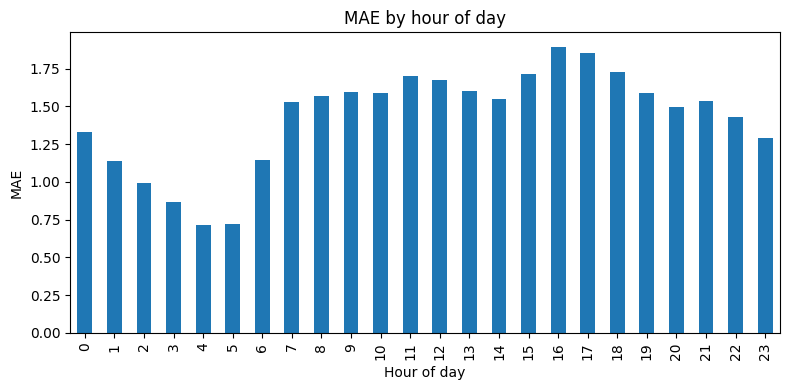

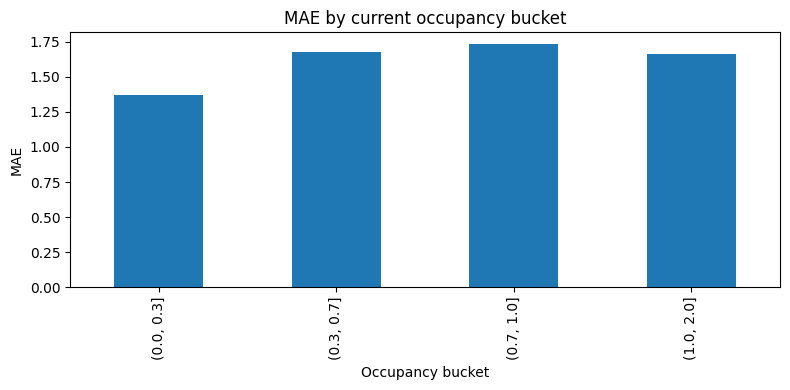

In [42]:
# MAE by hour of day
plt.figure(figsize=(8, 4))
ax = err_by_hour.plot(kind="bar", title="MAE by hour of day")
ax.set_xlabel("Hour of day")
ax.set_ylabel("MAE")
plt.tight_layout()
plt.show()

# MAE by occupancy bucket
plt.figure(figsize=(8, 4))
ax2 = err_by_occ.plot(kind="bar", title="MAE by current occupancy bucket")
ax2.set_xlabel("Occupancy bucket")
ax2.set_ylabel("MAE")
plt.tight_layout()
plt.show()

In [43]:
out_path = f"/kaggle/working/model_h{H}.joblib"

joblib.dump(
    {
        "model": model,
        "feat_cols": FEAT_COLS,
        "horizon_bins": int(max(1, H // BIN_MIN)),
    },
    out_path,
)

print("✓ Saved model pack to:", out_path)

✓ Saved model pack to: /kaggle/working/model_h60.joblib


## Conclusion and next steps

In this notebook we:

- loaded raw 5-minute Vélib' snapshots from a Kaggle dataset,
- explored the temporal coverage and station meta-data,
- built a feature stack combining:
  - temporal features (hour, day-of-week, cyclic encodings),
  - occupancy ratio,
  - spatial features (clusters + KNN distances + capacity transforms),
- defined a 60-minute ahead regression target,
- used a temporal 90/10 split for validation,
- trained an XGBoost model with Optuna-tuned hyperparameters,
- compared it against a persistence baseline,
- saved a model pack (`model_h60.joblib`) compatible with downstream use.

This exploratory notebook served as a blueprint for the [velo-paris](https://velo-paris.fr)
pipeline (batch jobs, API, monitoring). The production code reuses the same ideas:
strict time alignment, station-level feature engineering, and systematic comparison
against simple baselines.
